<a href="https://colab.research.google.com/github/YaokunLin/KaggleCodes/blob/main/Kaggle_WCB_V23_gbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import Series
import io
import time as time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
!pip install -U scikit-learn
import sklearn
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
#from mpl_toolkits.mplot3d import Axes3D
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

 
#uploaded = files.upload()
 
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
 
'''
df = pd.read_csv(path)
df.index=df["ClaimNumber"]
df.drop("ClaimNumber", axis = 1, inplace = True)
df
'''
 
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use','around'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use','left', 'right','around']) # adding new stopwords

!pip install catboost
from catboost import CatBoostRegressor

!pip install xgboost==1.3.3
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor,GradientBoostingRegressor

randSeed=123
__n_folds=5

from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

true_path = "/content/drive/MyDrive/Kaggle WCB competition/train.csv"
df_true = pd.read_csv(true_path)
df_true.index=df_true["ClaimNumber"]
df_true.drop("ClaimNumber", axis = 1, inplace = True)
df_trueCost=df_true.UltimateIncurredClaimCost

     |████████████████████████████████| 22.3MB 82.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 65.7MB 95kB/s 
     |████████████████████████████████| 157.5MB 43kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
%%time
test_path = "/content/drive/MyDrive/Kaggle WCB competition/test.csv"
df_test = pd.read_csv(test_path)
df_test.index=df_test["ClaimNumber"]
df_test.drop("ClaimNumber", axis = 1, inplace = True)

train_path = "/content/drive/MyDrive/Kaggle WCB competition/train.csv"
df_train = pd.read_csv(train_path)
df_train.index=df_train["ClaimNumber"]
df_train.drop("ClaimNumber", axis = 1, inplace = True)

##get ride of the two outliers
df_train["UltimateIncurredClaimCost"].clip(0, 1e6, inplace=True)

df_y_train= pd.Series(df_train['UltimateIncurredClaimCost'], name='UltimateIncurredClaimCost') 

df_X_train=df_train.drop(columns=['UltimateIncurredClaimCost'], axis=1)

df_X_whole=pd.concat([df_X_train, df_test])

df_X_whole['InitialIncurredCalimsCost'].clip(50, 1e6, inplace=True)

##Fix HoursWorkedPerWeek entry errors
MedianHrsWorkedPerWk=df_X_whole.groupby(['PartTimeFullTime','DaysWorkedPerWeek']).median()['HoursWorkedPerWeek']
def fix_HoursWorkedPerWeek(HoursWorkedPerWeek,PartTimeFullTime,DaysWorkedPerWeek):
 
    if HoursWorkedPerWeek<15 or HoursWorkedPerWeek>63:
        return MedianHrsWorkedPerWk[PartTimeFullTime][DaysWorkedPerWeek]
    else:
        return HoursWorkedPerWeek
 
df_X_whole['HoursWorkedPerWeek'] = df_X_whole.apply(lambda x: fix_HoursWorkedPerWeek(x['HoursWorkedPerWeek'], x['PartTimeFullTime'], x['DaysWorkedPerWeek']), axis=1)
 
 
df_X_whole['DateTimeOfAccident'] = pd.to_datetime(df_X_whole['DateTimeOfAccident'])
df_X_whole['DateReported'] = pd.to_datetime(df_X_whole['DateReported'])
def fix_DateReported(DateReported,DateTimeOfAccident):
 
    if DateReported<DateTimeOfAccident:
        return DateTimeOfAccident
    else:
        return DateReported

###add HourOfAccident feature
df_X_whole['HourOfAccident']  = pd.DatetimeIndex(df_X_whole['DateTimeOfAccident']).hour
df_X_whole['late_nite_acc']=df_X_whole['HourOfAccident'].isin([22, 23, 0,1,2,3,4,5]).astype(int) 
df_X_whole['morning_acc']=df_X_whole['HourOfAccident'].isin([6,7,8,9,10,11]).astype(int) 
df_X_whole['afternoon_acc']=df_X_whole['HourOfAccident'].isin([12,13,14,15,16,17]).astype(int) 
#df_X_whole['eve_acc']=df_X_whole['HourOfAccident'].isin([18,19,20,21]).astype(int) 
#df_X_whole['late_nite_acc'].sum(),df_X_whole['morning_acc'].sum(),df_X_whole['afternoon_acc'].sum(),df_X_whole['eve_acc'].sum()
#df_X_whole=df_X_whole.drop(['HourOfAccident'], axis=1)
###add HourOfAccident feature

df_X_whole['DateReported'] = df_X_whole.apply(lambda x: fix_DateReported(x['DateReported'], x['DateTimeOfAccident']), axis=1)
 
df_X_whole['MonthOfAccident'] = df_X_whole['DateTimeOfAccident'].apply(lambda date:date.month)
df_X_whole['MonthOfAccident'] = df_X_whole.MonthOfAccident.astype(str)
df_X_whole['Duration']=(df_X_whole['DateReported']-df_X_whole['DateTimeOfAccident']).astype('timedelta64[D]')
df_X_whole['YearOfAccident'] = df_X_whole['DateTimeOfAccident'].apply(lambda date:date.year)
df_X_whole = df_X_whole.drop('DateTimeOfAccident',axis=1)
df_X_whole['DateReported']=df_X_whole['DateReported'].dt.year +df_X_whole['DateReported'].dt.month/12+df_X_whole['DateReported'].dt.day/365

### Initial Cost IC Rating
Quantiles=[0.05,.1,0.15, .2,0.25, .3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]

df_X_whole_acc1988=df_X_whole[df_X_whole.YearOfAccident==1988]
df_X_whole_acc1988_IC_quant=df_X_whole_acc1988.InitialIncurredCalimsCost.quantile(Quantiles)



def RateIC(InitialIncurredCalimsCost,ICQuantileTable):
  if InitialIncurredCalimsCost<ICQuantileTable[0.05]:
    return 1
  elif InitialIncurredCalimsCost<ICQuantileTable[0.10]:
    return 2
  elif InitialIncurredCalimsCost<ICQuantileTable[0.15]:
    return 3
  elif InitialIncurredCalimsCost<ICQuantileTable[0.2]:
    return 4
  elif InitialIncurredCalimsCost<ICQuantileTable[0.25]:
    return 5
  elif InitialIncurredCalimsCost<ICQuantileTable[0.30]:
    return 6
  elif InitialIncurredCalimsCost<ICQuantileTable[0.35]:
    return 7
  elif InitialIncurredCalimsCost<ICQuantileTable[0.40]:
    return 8
  elif InitialIncurredCalimsCost<ICQuantileTable[0.45]:
    return 9
  elif InitialIncurredCalimsCost<ICQuantileTable[0.50]:
    return 10
  elif InitialIncurredCalimsCost<ICQuantileTable[0.55]:
    return 11
  elif InitialIncurredCalimsCost<ICQuantileTable[0.60]:
    return 12
  elif InitialIncurredCalimsCost<ICQuantileTable[0.65]:
    return 13
  elif InitialIncurredCalimsCost<ICQuantileTable[0.70]:
    return 14
  elif InitialIncurredCalimsCost<ICQuantileTable[0.75]:
    return 15
  elif InitialIncurredCalimsCost<ICQuantileTable[0.80]:
    return 16
  elif InitialIncurredCalimsCost<ICQuantileTable[0.85]:
    return 17
  elif InitialIncurredCalimsCost<ICQuantileTable[0.90]:
    return 18
  elif InitialIncurredCalimsCost<ICQuantileTable[0.95]:
    return 19
  else:
    return 20

df_X_whole_acc1988['ICRating'] = df_X_whole.apply(lambda x: RateIC(x['InitialIncurredCalimsCost'],df_X_whole_acc1988_IC_quant), axis=1)

ICRatingSeries=df_X_whole_acc1988['ICRating']

for accYr in range(1989,2006,1):
  df_X_whole_accYrTemp=df_X_whole[df_X_whole.YearOfAccident==accYr]
  df_X_whole_accYr_IC_quant=df_X_whole_accYrTemp.InitialIncurredCalimsCost.quantile(Quantiles)
  df_X_whole_accYrTemp['ICRating'] = df_X_whole.apply(lambda x: RateIC(x['InitialIncurredCalimsCost'],df_X_whole_accYr_IC_quant), axis=1)
  ICRatingSeries=pd.concat([ICRatingSeries,df_X_whole_accYrTemp['ICRating']])

df_X_whole=pd.concat([df_X_whole, ICRatingSeries],axis=1)
### Initial Cost IC Rating
Median_WeeklyWages=df_X_whole.groupby(['YearOfAccident','PartTimeFullTime','DaysWorkedPerWeek']).median()['WeeklyWages']
def fix_WeeklyWages(WeeklyWages,YearOfAccident,PartTimeFullTime,DaysWorkedPerWeek):
 
    if WeeklyWages<100 or WeeklyWages>1882:
        return Median_WeeklyWages[YearOfAccident][PartTimeFullTime][DaysWorkedPerWeek]
    else:
        return WeeklyWages

df_X_whole['WeeklyWages'] = df_X_whole.apply(lambda x: fix_WeeklyWages(x['WeeklyWages'], x['YearOfAccident'], x['PartTimeFullTime'],x['DaysWorkedPerWeek']), axis=1)
df_X_whole['WeeklyWages'].clip(10, df_X_whole['WeeklyWages'].max(), inplace=True)
 
df_X_whole.MaritalStatus.fillna('S',inplace = True)
df_X_whole['HrWorkedPerWorkDay']=df_X_whole['HoursWorkedPerWeek']/df_X_whole['DaysWorkedPerWeek']
df_X_whole['HourlyWage']=df_X_whole['WeeklyWages']/df_X_whole['HoursWorkedPerWeek']
 
df_X_whole['Gender'].loc[(df_X_whole['Gender'] =='U')] = 'M'
 
dummies = pd.get_dummies(df_X_whole[['Gender', 'MaritalStatus','PartTimeFullTime','MonthOfAccident' ]],drop_first=True)
df_X_whole = df_X_whole.drop(['Gender', 'MaritalStatus','PartTimeFullTime','MonthOfAccident'],axis=1)
df_X_whole = pd.concat([df_X_whole,dummies],axis=1)
 
df_X_whole['MarriedMaleDependentChildren']=(1-df_X_whole['MaritalStatus_S']-df_X_whole['MaritalStatus_U'])*df_X_whole['Gender_M']*df_X_whole['DependentChildren']










#%%time
def fit_lnUlcost_stndized(df_train_to_fit):
  #df_ulcost_train=pd.concat([df_train_to_fit.DateTimeOfAccident,df_train_to_fit.UltimateIncurredClaimCost],axis=1)
  #df_ulcost_train['DateTimeOfAccident'] = pd.to_datetime(df_ulcost_train['DateTimeOfAccident'])
  #df_ulcost_train['YearOfAccident'] = df_ulcost_train['DateTimeOfAccident'].apply(lambda date:date.year)
  df_ulcost_train=pd.concat([df_train_to_fit.YearOfAccident,df_train_to_fit.UltimateIncurredClaimCost],axis=1)
  df_ulcost_train['lnUlCost'] = np.log1p(df_ulcost_train.UltimateIncurredClaimCost)

  ulcost_train_YearOfAcc_array=df_ulcost_train['YearOfAccident'].unique()
  ulcost_train_YearOfAcc_list=np.sort(ulcost_train_YearOfAcc_array).tolist()
  ln_ulcost_mean_list=[]
  ln_ulcost_std_list=[]
  df_ulcost_train_1988=df_ulcost_train[df_ulcost_train.YearOfAccident==1900]
  ln_ulcost_mean_list.append(df_ulcost_train_1988.lnUlCost.mean())
  ln_ulcost_std_list.append(df_ulcost_train_1988.lnUlCost.std())
  df_ulcost_train_1988['ln_standized']=(df_ulcost_train_1988['lnUlCost']-df_ulcost_train_1988.lnUlCost.mean())/df_ulcost_train_1988.lnUlCost.std()

  df_ulcost_train_ln_standized=(df_ulcost_train_1988['lnUlCost']-df_ulcost_train_1988.lnUlCost.mean())/df_ulcost_train_1988.lnUlCost.std()

  for eachYr in ulcost_train_YearOfAcc_list:
    #print(eachYr)
    df_ulcost_train_temp=df_ulcost_train[df_ulcost_train.YearOfAccident==eachYr]
    lnUlCost_Mean_Temp=df_ulcost_train_temp.lnUlCost.mean()
    ln_ulcost_mean_list.append(lnUlCost_Mean_Temp)
    lnUlCost_Std_Temp=df_ulcost_train_temp.lnUlCost.std()
    ln_ulcost_std_list.append(lnUlCost_Std_Temp)
    #df_ulcost_train_temp['ln_standized']=((df_ulcost_train_temp['lnUlCost']-df_ulcost_train_temp.lnUlCost.mean())/df_ulcost_train_temp.lnUlCost.std())
    df_ulcost_train_ln_standized=pd.concat([df_ulcost_train_ln_standized,((df_ulcost_train_temp['lnUlCost']-df_ulcost_train_temp.lnUlCost.mean())/df_ulcost_train_temp.lnUlCost.std())])

  train_claim_number_list=list(df_ulcost_train.index)

  #train_claim_number_list

  ulcost_train_ln_standized_claim_number_list=list(df_ulcost_train_ln_standized.index)
  ulcost_train_ln_standized_list=list(df_ulcost_train_ln_standized)

  train_ulcost_standizedList=[]

  for eachClaim in train_claim_number_list:
    train_ulcost_standizedList.append(ulcost_train_ln_standized_list[ulcost_train_ln_standized_claim_number_list.index(eachClaim)])

  train_ulcost_standizedDF=pd.DataFrame(train_ulcost_standizedList,index=df_ulcost_train.index, columns=['ulCost_standized'])

  return pd.concat([df_train_to_fit,train_ulcost_standizedDF],axis=1),ulcost_train_YearOfAcc_list,ln_ulcost_mean_list,ln_ulcost_std_list
  #return train_ulcost_standizedDF,ulcost_train_YearOfAcc_list,ln_ulcost_mean_list,ln_ulcost_std_list

def invtransform_lnUlcost_stndized(df_to_invtransform,ulcost_train_YearOfAcc_list,ln_ulcost_mean_list,ln_ulcost_std_list):

  df_to_invtransform=pd.concat([df_to_invtransform.YearOfAccident,df_to_invtransform.lnUlCost_Standized],axis=1)
  invtransform_claim_number_list=list(df_to_invtransform.index)
  invtransform_claim_Yr_list=list(df_to_invtransform.YearOfAccident)
  invtransform_claim_ulCost_standized_list=list(df_to_invtransform.lnUlCost_Standized)

  trandsformed_list=[]
  idx=0

  for eachYr in invtransform_claim_Yr_list:
    mean_temp=ln_ulcost_mean_list[ulcost_train_YearOfAcc_list.index(eachYr)]
    std_temp=ln_ulcost_std_list[ulcost_train_YearOfAcc_list.index(eachYr)]
    ulCost_standized_cost_temp=invtransform_claim_ulCost_standized_list[idx]
    transformed_temp=ulCost_standized_cost_temp*std_temp+mean_temp
    transformed_temp=np.expm1(transformed_temp)
    trandsformed_list.append(transformed_temp)
    idx=idx+1


  return pd.concat([df_to_invtransform,pd.DataFrame(trandsformed_list,index=df_to_invtransform.index,columns=['InvTranUlCost'])],axis=1)


# Defining a function to convert our descriptions to word tokens and remove ponctuation
def sent_to_words(descriptions):
    i = 0
    for description in descriptions:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(description), deacc=True)) 
        
# Defining a function to remove stopwords    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

'''
proccessed_words_X_whole = (sent_to_words(df_X_whole.ClaimDescription))
proccessed_words_X_whole = remove_stopwords(proccessed_words_X_whole)

proccessed_words_X_whole=pd.DataFrame(proccessed_words_X_whole,index=df_X_whole.index)
proccessed_words_X_whole['proccessed_words_X_whole'] = proccessed_words_X_whole[proccessed_words_X_whole.columns[0:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

proccessed_words_X_whole=proccessed_words_X_whole.proccessed_words_X_whole
'''


import itertools
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))


def fit_lnIniCost_stndized(df_train_to_fit):

  df_inicost_train=pd.concat([df_train_to_fit.YearOfAccident,df_train_to_fit.InitialIncurredCalimsCost],axis=1)
  df_inicost_train['lnIniCost'] = np.log1p(df_inicost_train.InitialIncurredCalimsCost)

  inicost_train_YearOfAcc_array=df_inicost_train['YearOfAccident'].unique()
  inicost_train_YearOfAcc_list=np.sort(inicost_train_YearOfAcc_array).tolist()
  ln_inicost_mean_list=[]
  ln_inicost_std_list=[]
  df_inicost_train_1988=df_inicost_train[df_inicost_train.YearOfAccident==1988]
  ln_inicost_mean_list.append(df_inicost_train_1988.lnIniCost.mean())
  ln_inicost_std_list.append(df_inicost_train_1988.lnIniCost.std())
  df_inicost_train_1988['ln_standized']=(df_inicost_train_1988['lnIniCost']-df_inicost_train_1988.lnIniCost.mean())/df_inicost_train_1988.lnIniCost.std()

  df_inicost_train_ln_standized=(df_inicost_train_1988['lnIniCost']-df_inicost_train_1988.lnIniCost.mean())/df_inicost_train_1988.lnIniCost.std()

  for eachYr in inicost_train_YearOfAcc_list[1:]:
    #print(eachYr)
    df_inicost_train_temp=df_inicost_train[df_inicost_train.YearOfAccident==eachYr]
    lnIniCost_Mean_Temp=df_inicost_train_temp.lnIniCost.mean()
    ln_inicost_mean_list.append(lnIniCost_Mean_Temp)
    lnIniCost_Std_Temp=df_inicost_train_temp.lnIniCost.std()
    ln_inicost_std_list.append(lnIniCost_Std_Temp)
    #df_inicost_train_temp['ln_standized']=((df_inicost_train_temp['lnIniCost']-df_inicost_train_temp.lnIniCost.mean())/df_inicost_train_temp.lnIniCost.std())
    df_inicost_train_ln_standized=pd.concat([df_inicost_train_ln_standized,((df_inicost_train_temp['lnIniCost']-df_inicost_train_temp.lnIniCost.mean())/df_inicost_train_temp.lnIniCost.std())])

  train_claim_number_list=list(df_inicost_train.index)

  #train_claim_number_list

  inicost_train_ln_standized_claim_number_list=list(df_inicost_train_ln_standized.index)
  inicost_train_ln_standized_list=list(df_inicost_train_ln_standized)

  train_inicost_standizedList=[]

  for eachClaim in train_claim_number_list:
    train_inicost_standizedList.append(inicost_train_ln_standized_list[inicost_train_ln_standized_claim_number_list.index(eachClaim)])

  train_inicost_standizedDF=pd.DataFrame(train_inicost_standizedList,index=df_inicost_train.index, columns=['iniCost_standized'])

  return pd.concat([df_train_to_fit,train_inicost_standizedDF],axis=1),inicost_train_YearOfAcc_list,ln_inicost_mean_list,ln_inicost_std_list
  #return train_inicost_standizedDF,inicost_train_YearOfAcc_list,ln_inicost_mean_list,ln_inicost_std_list

def go_curve(df):
  
  df['Age_SQ']=df.Age**2
  df['Age_SRT']=df.Age**0.5
  df['Age^3']=df.Age**3
  df['ln_Age_']=np.log1p(df.Age)
  df['1/Age']=1/(1+df.Age)
  
  df['DependentChildren_SQ']=df.DependentChildren**2
  df['DependentChildren_SRT']=df.DependentChildren**0.5
  df['DependentChildren^3']=df.DependentChildren**3
  df['ln_DependentChildren_']=np.log1p(df.DependentChildren)
  df['1/DependentChildren']=1/(1+df.DependentChildren)

  df['InitialIncurredCalimsCost_SQ']=df.InitialIncurredCalimsCost**2
  df['InitialIncurredCalimsCost_SRT']=df.InitialIncurredCalimsCost**0.5
  df['InitialIncurredCalimsCost^3']=df.InitialIncurredCalimsCost**3
  df['ln_InitialIncurredCalimsCost_']=np.log1p(df.InitialIncurredCalimsCost)
  df['1/InitialIncurredCalimsCost']=1/(1+df.InitialIncurredCalimsCost)

  df['Duration_SQ']=df.Duration**2
  df['Duration_SRT']=df.Duration**0.5
  df['Duration^3']=df.Duration**3
  df['ln_Duration_']=np.log1p(df.Duration)
  df['1/Duration']=1/(1+df.Duration)

  df['YearOfAccident_SQ']=df.YearOfAccident**2
  df['YearOfAccident_SRT']=df.YearOfAccident**0.5
  df['YearOfAccident^3']=df.YearOfAccident**3
  df['ln_YearOfAccident_']=np.log1p(df.YearOfAccident)
  df['1/YearOfAccident']=1/(1+df.YearOfAccident)

  df['HrWorkedPerWorkDay_SQ']=df.HrWorkedPerWorkDay**2
  df['HrWorkedPerWorkDay_SRT']=df.HrWorkedPerWorkDay**0.5
  df['HrWorkedPerWorkDay^3']=df.HrWorkedPerWorkDay**3
  df['ln_HrWorkedPerWorkDay_']=np.log1p(df.HrWorkedPerWorkDay)
  df['1/HrWorkedPerWorkDay']=1/(1+df.HrWorkedPerWorkDay)

  df['HourlyWage_SQ']=df.HourlyWage**2
  df['HourlyWage_SRT']=df.HourlyWage**0.5
  df['HourlyWage^3']=df.HourlyWage**3
  df['ln_HourlyWage_']=np.log1p(df.HourlyWage)
  df['1/HourlyWage']=1/(1+df.HourlyWage)

  df['ICRating_SQ']=df.ICRating**2
  df['ICRating_SRT']=df.ICRating**0.5
  df['ICRating^3']=df.ICRating**3
  df['ln_ICRating_']=np.log1p(df.ICRating)
  df['1/ICRating']=1/(1+df.ICRating)

  df['iniCost_standized_SQ']=df.iniCost_standized**2
  #df['iniCost_standized^0.5']=df.iniCost_standized**(1/3)
  df['iniCost_standized^3']=df.iniCost_standized**3
  #df['ln_iniCost_standized_']=np.log1p(df.iniCost_standized)
  df['1/iniCost_standized']=1/(1+df.iniCost_standized)

  df['IniCostOverWeeklyWage_SQ']=df.IniCostOverWeeklyWage**2
  df['IniCostOverWeeklyWage_SRT']=df.IniCostOverWeeklyWage**0.5
  df['IniCostOverWeeklyWage^3']=df.IniCostOverWeeklyWage**3
  df['1/IniCostOverWeeklyWage']=1/(1+df.IniCostOverWeeklyWage)

  df['lnUlCost_meta_SQ']=df.lnUlCost_meta**2
  #df['lnUlCost_meta^0.5']=df.lnUlCost_meta**(1/3)
  df['lnUlCost_meta^3']=df.lnUlCost_meta**3
  df['1/lnUlCost_meta']=1/(1+df.lnUlCost_meta)

  df['ComplicationFactor_GroupBY_YOA_IC_SQ']=df.ComplicationFactor_GroupBY_YOA_IC**2
  df['ComplicationFactor_GroupBY_YOA_IC_SRT']=df.ComplicationFactor_GroupBY_YOA_IC**0.5
  df['ComplicationFactor_GroupBY_YOA_IC^3']=df.ComplicationFactor_GroupBY_YOA_IC**3
  df['1/ComplicationFactor_GroupBY_YOA_IC']=1/(1+df.ComplicationFactor_GroupBY_YOA_IC)
  '''
  df['ClaimDescriptionScore_SQ']=df.ClaimDescriptionScore**2
  df['ClaimDescriptionScore^3']=df.ClaimDescriptionScore**3
  df['1/ClaimDescriptionScore']=1/(1+df.ClaimDescriptionScore)
  
  df['topic_1_SQ']=df.topic_1**2
  df['topic_1_SRT']=df.topic_1**0.5
  df['topic_1^3']=df.topic_1**3
  df['1/topic_1']=1/(1+df.topic_1)
  
  ClaimDescriptionScore_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df.ClaimDescriptionScore],columns=['ClaimDescriptionScore^1/3'],index=df.index)
  '''
  lnUlCost_meta_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df.lnUlCost_meta],columns=['lnUlCost_meta^1/3'],index=df.index)
  iniCost_standized_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df.iniCost_standized],columns=['iniCost_standized^1/3'],index=df.index)
  return pd.concat([df,lnUlCost_meta_root,iniCost_standized_root],axis=1)


df_X_whole,inicost_train_YearOfAcc_list,ln_inicost_mean_list,ln_inicost_std_list=fit_lnIniCost_stndized(df_X_whole)

df_X_whole['IniCostOverWeeklyWage']=df_X_whole['InitialIncurredCalimsCost']/df_X_whole['WeeklyWages']
df_X_whole['IniCostOverWeeklyWage'].clip(0, 250, inplace=True)

df_X_whole['ln_IniCostOverWeeklyWage']=np.log1p(df_X_whole.IniCostOverWeeklyWage)

'''
RandF_LnCost_Score_Path='/content/drive/MyDrive/Kaggle WCB competition/Score_List_RanF 27704.csv'
df_RandF_LnCost_Score = pd.read_csv(RandF_LnCost_Score_Path)
df_RandF_LnCost_Score.index=df_RandF_LnCost_Score["ClaimNumber"]
df_RandF_LnCost_Score.drop("ClaimNumber", axis = 1, inplace = True)
df_RandF_LnCost_Score.columns=['lnUlCost_Standized_RandF']

df_X_whole=pd.concat([df_X_whole,df_RandF_LnCost_Score],axis=1)
'''


df_test_cleaned=df_X_whole[-len(df_test):]
df_train_cleaned=df_X_whole.head(len(df_X_train))

df_train_cleaned_Xy=pd.concat([df_train_cleaned,df_train.UltimateIncurredClaimCost],axis=1)

df_train_cleaned_Xy['complication_factor']=df_train_cleaned_Xy.UltimateIncurredClaimCost/df_train_cleaned_Xy.InitialIncurredCalimsCost

df_train_cleaned_Xy['complication_factor'].clip(0, 10, inplace=True)
#df_train_cleaned_Xy.complication_factor.sort_values().head(1000)

df_train_cleaned_Xy['ln_complication_factor']=np.log1p(df_train_cleaned_Xy.complication_factor)


GBM_lnUlCost_Score_val_name='val_lnUlCost_Score_GBM_27633.csv'
GBM_lnUlCost_Score_val_name='/content/drive/MyDrive/Kaggle WCB competition/'+GBM_lnUlCost_Score_val_name  
GBM_lnUlCost_Score_val_file=pd.read_csv(GBM_lnUlCost_Score_val_name, index_col=0)
GBM_lnUlCost_Score_val_file.columns=['lnUlCost_GBM'] #val_lnUlCost_GBM
df_train_cleaned_Xy = pd.concat([df_train_cleaned_Xy,GBM_lnUlCost_Score_val_file],axis=1)

GBM_lnUlCost_Score_test_name='test_lnUlCost_Score_list_GBM_27633.csv'
GBM_lnUlCost_Score_test_name='/content/drive/MyDrive/Kaggle WCB competition/'+GBM_lnUlCost_Score_test_name
GBM_lnUlCost_Score_test_file=pd.read_csv(GBM_lnUlCost_Score_test_name, index_col=0)
GBM_lnUlCost_Score_test_file.columns=['lnUlCost_GBM'] #test_lnUlCost_GBM
df_test_cleaned = pd.concat([df_test_cleaned,GBM_lnUlCost_Score_test_file],axis=1)

MLP_lnUlCost_Score_val_name='val_lnUlCost_Score_MLP_27709.csv'
MLP_lnUlCost_Score_val_name='/content/drive/MyDrive/Kaggle WCB competition/'+MLP_lnUlCost_Score_val_name  
MLP_lnUlCost_Score_val_file=pd.read_csv(MLP_lnUlCost_Score_val_name, index_col=0)
MLP_lnUlCost_Score_val_file.columns=['lnUlCost_MLP'] #val_lnUlCost_MLP
df_train_cleaned_Xy = pd.concat([df_train_cleaned_Xy,MLP_lnUlCost_Score_val_file],axis=1)

MLP_lnUlCost_Score_test_name='test_lnUlCost_Score_list_MLP_27709.csv'
MLP_lnUlCost_Score_test_name='/content/drive/MyDrive/Kaggle WCB competition/'+MLP_lnUlCost_Score_test_name
MLP_lnUlCost_Score_test_file=pd.read_csv(MLP_lnUlCost_Score_test_name, index_col=0)
MLP_lnUlCost_Score_test_file.columns=['lnUlCost_MLP'] #test_lnUlCost_MLP
df_test_cleaned = pd.concat([df_test_cleaned,MLP_lnUlCost_Score_test_file],axis=1)

RandF_lnUlCost_Score_val_name='val_lnUlCost_Score_RandF_27586.csv'
RandF_lnUlCost_Score_val_name='/content/drive/MyDrive/Kaggle WCB competition/'+RandF_lnUlCost_Score_val_name  
RandF_lnUlCost_Score_val_file=pd.read_csv(RandF_lnUlCost_Score_val_name, index_col=0)
RandF_lnUlCost_Score_val_file.columns=['lnUlCost_RandF'] #val_lnUlCost_RandF
df_train_cleaned_Xy = pd.concat([df_train_cleaned_Xy,RandF_lnUlCost_Score_val_file],axis=1)

RandF_lnUlCost_Score_test_name='test_lnUlCost_Score_list_RanF_27586.csv'
RandF_lnUlCost_Score_test_name='/content/drive/MyDrive/Kaggle WCB competition/'+RandF_lnUlCost_Score_test_name
RandF_lnUlCost_Score_test_file=pd.read_csv(RandF_lnUlCost_Score_test_name, index_col=0)
RandF_lnUlCost_Score_test_file.columns=['lnUlCost_RandF'] #test_lnUlCost_RandF
df_test_cleaned = pd.concat([df_test_cleaned,RandF_lnUlCost_Score_test_file],axis=1)

meta_lnUlCost_Score_val_name='val_lnUlCost_Score_list_ensembled.csv'
meta_lnUlCost_Score_val_name='/content/drive/MyDrive/Kaggle WCB competition/'+meta_lnUlCost_Score_val_name  
meta_lnUlCost_Score_val_file=pd.read_csv(meta_lnUlCost_Score_val_name, index_col=0)
meta_lnUlCost_Score_val_file.columns=['lnUlCost_meta'] #val_lnUlCost_meta
df_train_cleaned_Xy = pd.concat([df_train_cleaned_Xy,meta_lnUlCost_Score_val_file],axis=1)

meta_lnUlCost_Score_test_name='test_lnUlCost_Score_list_ensembled.csv'
meta_lnUlCost_Score_test_name='/content/drive/MyDrive/Kaggle WCB competition/'+meta_lnUlCost_Score_test_name
meta_lnUlCost_Score_test_file=pd.read_csv(meta_lnUlCost_Score_test_name, index_col=0)
meta_lnUlCost_Score_test_file.columns=['lnUlCost_meta'] #test_lnUlCost_meta
df_test_cleaned = pd.concat([df_test_cleaned,meta_lnUlCost_Score_test_file],axis=1)

###group ul_cost by Yr of accident and IC
df_train_cleaned_Xy["MedianUlCost_GroupBY_YOA_IC"] = df_train_cleaned_Xy.groupby(["YearOfAccident",'ICRating'])["UltimateIncurredClaimCost"].transform("median")

YoA_IC_GroupedTbl=df_train_cleaned_Xy.groupby(["YearOfAccident",'ICRating'])["UltimateIncurredClaimCost"].median()
def LookUp_MedianUlCost_GroupBY_YOA_IC(YOA,IC):
  return YoA_IC_GroupedTbl[YOA][IC]
df_test_cleaned['MedianUlCost_GroupBY_YOA_IC'] = df_test_cleaned.apply(lambda x: LookUp_MedianUlCost_GroupBY_YOA_IC(x['YearOfAccident'],x['ICRating']), axis=1)

df_train_cleaned_Xy["ComplicationFactor_GroupBY_YOA_IC"] = df_train_cleaned_Xy.MedianUlCost_GroupBY_YOA_IC/df_train_cleaned_Xy.InitialIncurredCalimsCost
df_train_cleaned_Xy.ComplicationFactor_GroupBY_YOA_IC.clip(0, 10, inplace=True)
df_train_cleaned_Xy["lnComplicationFactor_GroupBY_YOA_IC"]=np.log1p(df_train_cleaned_Xy.ComplicationFactor_GroupBY_YOA_IC)

df_test_cleaned["ComplicationFactor_GroupBY_YOA_IC"] = df_test_cleaned.MedianUlCost_GroupBY_YOA_IC/df_test_cleaned.InitialIncurredCalimsCost
df_test_cleaned.ComplicationFactor_GroupBY_YOA_IC.clip(0, 10, inplace=True)
df_test_cleaned["lnComplicationFactor_GroupBY_YOA_IC"]=np.log1p(df_test_cleaned.ComplicationFactor_GroupBY_YOA_IC)
###group ul_cost by Yr of accident and IC

####ClaimDescriptionScore
ClaimDescriptionScore_file_name= "ClaimDescriptionScore.csv"  
ClaimDescriptionScore_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+ClaimDescriptionScore_file_name
ClaimDescriptionScore_file = pd.read_csv(ClaimDescriptionScore_file_name, index_col=0)
ClaimDescriptionScore_file_train=ClaimDescriptionScore_file.head(len(df_X_train))
ClaimDescriptionScore_file_test=ClaimDescriptionScore_file[-len(df_test):]
df_train_cleaned_Xy = pd.concat([df_train_cleaned_Xy,ClaimDescriptionScore_file_train],axis=1)
df_test_cleaned = pd.concat([df_test_cleaned,ClaimDescriptionScore_file_test],axis=1)

CD_Score_file_name="2_CDScore.csv"  
CD_Score_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+CD_Score_file_name
CD_Score_file = pd.read_csv(CD_Score_file_name, index_col=0)
CD_Score_file=CD_Score_file.drop(['ClaimDescriptionScore','freq_InitialIncurredCalimsCost','max_topic_2'],axis=1)
CD_Score_file_train=CD_Score_file.head(len(df_X_train))
CD_Score_file_test=CD_Score_file[-len(df_test):]

df_train_cleaned_Xy = pd.concat([df_train_cleaned_Xy,CD_Score_file_train],axis=1)
df_test_cleaned = pd.concat([df_test_cleaned,CD_Score_file_test],axis=1)
####ClaimDescriptionScore

'''
df_train_cleaned_Xy=go_curve(df_train_cleaned_Xy)
df_test_cleaned=go_curve(df_test_cleaned)
'''


CPU times: user 5min 41s, sys: 751 ms, total: 5min 42s
Wall time: 5min 46s


In [ ]:
!pip install -U catboost
from catboost import CatBoostRegressor
from catboost import Pool as CatBoostPool # Careful because I use the name "Pool" from Multiprocessing in part 3 !!

Requirement already up-to-date: catboost in /usr/local/lib/python3.7/dist-packages (0.24.4)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
skf = StratifiedKFold(n_splits=10, random_state = 123, shuffle = True)
CD_Score_topics_exclude_columns=['ClaimDescriptionScore','freq_InitialIncurredCalimsCost']
grid_params={'NMF_topics':[5,10,15,20,25,30],
             'NMF_LR':[True,False],
             'NMF_G':[1,2],

             'LDA_topics':[5,10,15,20,25,30],
             'LDA_LR':[True,False],

             'cluster_on_stand':[True],
             #'n_clusters':[0,2,5,10,15,20,25],
             'n_clusters':[0,5,10,15,20],


             #'To_Standardized':[False],
             'To_MinMax':[False],
             'min_samples_leaf':[55,60,65]
             #'min_samples_leaf':[5,10,20,25]
             #'MLP_layers':[(300,300,300,200,100,),(400,300,200,100,),(300,200,100,),(200,100,)]
                        
             }

grid_params={'NMF_topics':[5],
             'NMF_LR':[True],
             'NMF_G':[1],

             'LDA_topics':[5],
             'LDA_LR':[False],

             'cluster_on_stand':[True],
             #'n_clusters':[0,2,5,10,15,20,25],
             'n_clusters':[0],


             #'To_Standardized':[False],
             'To_MinMax':[False],
             #'min_samples_leaf':[5,10,20,25]
             #'MLP_layers':[(300,300,300,200,100,),(400,300,200,100,),(300,200,100,),(200,100,)]

             #'CD_Score_topics':[2],#[0,2,10,20,30,40,50,60],
             'min_samples_leaf':[60],

             'Age_curve':[True,False],
             'DependentChildren_curve':[True,False],
             'InitialIncurredCalimsCost_curve':[True,False],
             'Duration_curve':[True,False],
             'YearOfAccident_curve':[True,False],
             'HrWorkedPerWorkDay_curve':[True,False],
             'HourlyWage_curve':[True,False],
             'ICRating_curve':[True,False],
             'iniCost_standized_Curve':[False],
             'lnUlCost_meta_Curve':[True,False],
             'ComplicationFactor_GroupBY_YOA_IC_curve':[False],
             'soft_tissue':[True,False],
             'CD_Score_Curve':[False],
             'topic1_curve':[True,False],
             'freq_ini_cost_curve':[True,False],

             #'learning_rate':[0.01/2, 0.01, 0.1/2, 0.1], #0.001, 
             'top':[0,10,50,100],   
             'n_gram':[1,10],           
             }



globalRMSE=[]
for i, p in enumerate(product_dict(**grid_params)):
  #cat_params = {
   #       'random_seed': 123, 'eval_metric': 'RMSE', 'iterations': 2000, "learning_rate" : p['learning_rate'] #'task_type': 'GPU' #"learning_rate" : .1,
   #      }



  print(i)
  print(p)
  rmseList=[]
  test_UlCost_List=[]
  val_UlCost_List=[]
  

  ###NMF
  if p['NMF_LR']:
    if p['NMF_G']==1:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF.csv"
    else:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF_(1,2).csv"
  else:
    if p['NMF_G']==1:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF_NoLR.csv"
    else:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF_(1,2)_NoLR.csv"

  print(NMF_file_name)
  NMF_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+NMF_file_name
  NMF_file = pd.read_csv(NMF_file_name, index_col=0)
  NMF_file_train=NMF_file.head(len(df_X_train))
  NMF_file_test=NMF_file[-len(df_test):]
  ###NMF

  ###LDA###
  if p['LDA_LR']:
    LDA_file_name=str(p['LDA_topics']) + "_" + "LDA.csv"
  else:
    LDA_file_name=str(p['LDA_topics']) + "_" + "LDA_NoLR.csv"
  
  print(LDA_file_name)
  LDA_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+LDA_file_name
  LDA_file = pd.read_csv(LDA_file_name, index_col=0)
  LDA_file_train=LDA_file.head(len(df_X_train))
  LDA_file_test=LDA_file[-len(df_test):]
  ###LDA###

  df_train_lnComplication_factor_Xy = pd.concat([df_train_cleaned_Xy,NMF_file_train,LDA_file_train],axis=1)
  df_test_lnComplication_factor = pd.concat([df_test_cleaned,NMF_file_test,LDA_file_test],axis=1)

  ##clustering
  if p['n_clusters']>0:
    if p['cluster_on_stand']:
      cluster_file_name=str(p['n_clusters'])+ "_" +"KM_stand.csv"
    else:
      cluster_file_name=str(p['n_clusters'])+ "_" +"KM_MinMax.csv"
  
    print(cluster_file_name)
    cluster_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+cluster_file_name
    cluster_file = pd.read_csv(cluster_file_name, index_col=0)
    cluster_file_train=cluster_file.head(len(df_X_train))
    cluster_file_test=cluster_file[-len(df_test):]

    df_train_lnComplication_factor_Xy = pd.concat([df_train_lnComplication_factor_Xy,cluster_file_train],axis=1)
    df_test_lnComplication_factor = pd.concat([df_test_lnComplication_factor,cluster_file_test],axis=1)
  ##clustering

  ###Soft Tissue###
  if p['soft_tissue']:
    soft_tissue_name='soft tissue - csv.csv'
    print(soft_tissue_name)
    soft_tissue_name='/content/drive/MyDrive/Kaggle WCB competition/'+soft_tissue_name
    soft_tissue_file = pd.read_csv(soft_tissue_name, index_col=0)
    soft_tissue_file_train=soft_tissue_file.head(len(df_X_train))
    soft_tissue_file_test=soft_tissue_file[-len(df_test):]
    df_train_lnComplication_factor_Xy = pd.concat([df_train_lnComplication_factor_Xy,soft_tissue_file_train],axis=1)
    df_test_lnComplication_factor = pd.concat([df_test_lnComplication_factor,soft_tissue_file_test],axis=1)
  ###Soft Tissue###

  ###CD_Score_Curve###
  if p['CD_Score_Curve']:
      df_train_lnComplication_factor_Xy['ClaimDescriptionScore_SQ']=df_train_lnComplication_factor_Xy.ClaimDescriptionScore**2
      df_train_lnComplication_factor_Xy['ClaimDescriptionScore^3']=df_train_lnComplication_factor_Xy.ClaimDescriptionScore**3
      df_train_lnComplication_factor_Xy['1/ClaimDescriptionScore']=1/(1+df_train_lnComplication_factor_Xy.ClaimDescriptionScore)
      ClaimDescriptionScore_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.ClaimDescriptionScore],columns=['ClaimDescriptionScore^1/3'],index=df_train_lnComplication_factor_Xy.index)
      df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,ClaimDescriptionScore_root],axis=1)

      df_test_lnComplication_factor['ClaimDescriptionScore_SQ']=df_test_lnComplication_factor.ClaimDescriptionScore**2
      df_test_lnComplication_factor['ClaimDescriptionScore^3']=df_test_lnComplication_factor.ClaimDescriptionScore**3
      df_test_lnComplication_factor['1/ClaimDescriptionScore']=1/(1+df_test_lnComplication_factor.ClaimDescriptionScore)
      ClaimDescriptionScore_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.ClaimDescriptionScore],columns=['ClaimDescriptionScore^1/3'],index=df_test_lnComplication_factor.index)
      df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,ClaimDescriptionScore_root],axis=1)
  ###CD_Score_Curve###

  ###iniCost_standized_Curve###
  if p['iniCost_standized_Curve']:
      df_train_lnComplication_factor_Xy['iniCost_standized_SQ']=df_train_lnComplication_factor_Xy.iniCost_standized**2
      df_train_lnComplication_factor_Xy['iniCost_standized^3']=df_train_lnComplication_factor_Xy.iniCost_standized**3
      df_train_lnComplication_factor_Xy['1/iniCost_standized']=1/(1+df_train_lnComplication_factor_Xy.iniCost_standized)
      iniCost_standized_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.iniCost_standized],columns=['iniCost_standized^1/3'],index=df_train_lnComplication_factor_Xy.index)
      df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,iniCost_standized_root],axis=1)

      df_test_lnComplication_factor['iniCost_standized_SQ']=df_test_lnComplication_factor.iniCost_standized**2
      df_test_lnComplication_factor['iniCost_standized^3']=df_test_lnComplication_factor.iniCost_standized**3
      df_test_lnComplication_factor['1/iniCost_standized']=1/(1+df_test_lnComplication_factor.iniCost_standized)
      iniCost_standized_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.iniCost_standized],columns=['iniCost_standized^1/3'],index=df_test_lnComplication_factor.index)
      df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,iniCost_standized_root],axis=1)
  ###iniCost_standized_Curve###

    ###lnUlCost_meta_Curve###
  if p['lnUlCost_meta_Curve']:
      df_train_lnComplication_factor_Xy['lnUlCost_meta_SQ']=df_train_lnComplication_factor_Xy.lnUlCost_meta**2
      df_train_lnComplication_factor_Xy['lnUlCost_meta^3']=df_train_lnComplication_factor_Xy.lnUlCost_meta**3
      df_train_lnComplication_factor_Xy['1/lnUlCost_meta']=1/(1+df_train_lnComplication_factor_Xy.lnUlCost_meta)
      lnUlCost_meta_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.lnUlCost_meta],columns=['lnUlCost_meta^1/3'],index=df_train_lnComplication_factor_Xy.index)
      df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,lnUlCost_meta_root],axis=1)

      df_test_lnComplication_factor['lnUlCost_meta_SQ']=df_test_lnComplication_factor.lnUlCost_meta**2
      df_test_lnComplication_factor['lnUlCost_meta^3']=df_test_lnComplication_factor.lnUlCost_meta**3
      df_test_lnComplication_factor['1/lnUlCost_meta']=1/(1+df_test_lnComplication_factor.lnUlCost_meta)
      lnUlCost_meta_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.lnUlCost_meta],columns=['lnUlCost_meta^1/3'],index=df_test_lnComplication_factor.index)
      df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,lnUlCost_meta_root],axis=1)
  ###lnUlCost_meta_Curve###

  ###topic1_curve###
  if p['topic1_curve']:
    df_train_lnComplication_factor_Xy['topic_1_SQ']=df_train_lnComplication_factor_Xy.topic_1**2
    df_train_lnComplication_factor_Xy['topic_1_SRT']=df_train_lnComplication_factor_Xy.topic_1**0.5
    df_train_lnComplication_factor_Xy['topic_1^3']=df_train_lnComplication_factor_Xy.topic_1**3
    df_train_lnComplication_factor_Xy['1/topic_1']=1/(1+df_train_lnComplication_factor_Xy.topic_1)

    df_test_lnComplication_factor['topic_1_SQ']=df_test_lnComplication_factor.topic_1**2
    df_test_lnComplication_factor['topic_1_SRT']=df_test_lnComplication_factor.topic_1**0.5
    df_test_lnComplication_factor['topic_1^3']=df_test_lnComplication_factor.topic_1**3
    df_test_lnComplication_factor['1/topic_1']=1/(1+df_test_lnComplication_factor.topic_1)
  ###topic1_curve###

  ###Age_curve###
  if p['Age_curve']:
    df_train_lnComplication_factor_Xy['Age_SQ']=df_train_lnComplication_factor_Xy.Age**2
    df_train_lnComplication_factor_Xy['Age_SRT']=df_train_lnComplication_factor_Xy.Age**0.5
    df_train_lnComplication_factor_Xy['Age^3']=df_train_lnComplication_factor_Xy.Age**3
    df_train_lnComplication_factor_Xy['1/Age']=1/(1+df_train_lnComplication_factor_Xy.Age)

    df_test_lnComplication_factor['Age_SQ']=df_test_lnComplication_factor.Age**2
    df_test_lnComplication_factor['Age_SRT']=df_test_lnComplication_factor.Age**0.5
    df_test_lnComplication_factor['Age^3']=df_test_lnComplication_factor.Age**3
    df_test_lnComplication_factor['1/Age']=1/(1+df_test_lnComplication_factor.Age)
  ###Age_curve###

  ###DependentChildren_curve###
  if p['DependentChildren_curve']:
    df_train_lnComplication_factor_Xy['DependentChildren_SQ']=df_train_lnComplication_factor_Xy.DependentChildren**2
    df_train_lnComplication_factor_Xy['DependentChildren_SRT']=df_train_lnComplication_factor_Xy.DependentChildren**0.5
    df_train_lnComplication_factor_Xy['DependentChildren^3']=df_train_lnComplication_factor_Xy.DependentChildren**3
    df_train_lnComplication_factor_Xy['1/DependentChildren']=1/(1+df_train_lnComplication_factor_Xy.DependentChildren)

    df_test_lnComplication_factor['DependentChildren_SQ']=df_test_lnComplication_factor.DependentChildren**2
    df_test_lnComplication_factor['DependentChildren_SRT']=df_test_lnComplication_factor.DependentChildren**0.5
    df_test_lnComplication_factor['DependentChildren^3']=df_test_lnComplication_factor.DependentChildren**3
    df_test_lnComplication_factor['1/DependentChildren']=1/(1+df_test_lnComplication_factor.DependentChildren)
  ###DependentChildren_curve###

  ###InitialIncurredCalimsCost_curve###
  if p['InitialIncurredCalimsCost_curve']:
    df_train_lnComplication_factor_Xy['InitialIncurredCalimsCost_SQ']=df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost**2
    df_train_lnComplication_factor_Xy['InitialIncurredCalimsCost_SRT']=df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost**0.5
    df_train_lnComplication_factor_Xy['InitialIncurredCalimsCost^3']=df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost**3
    df_train_lnComplication_factor_Xy['1/InitialIncurredCalimsCost']=1/(1+df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost)

    df_test_lnComplication_factor['InitialIncurredCalimsCost_SQ']=df_test_lnComplication_factor.InitialIncurredCalimsCost**2
    df_test_lnComplication_factor['InitialIncurredCalimsCost_SRT']=df_test_lnComplication_factor.InitialIncurredCalimsCost**0.5
    df_test_lnComplication_factor['InitialIncurredCalimsCost^3']=df_test_lnComplication_factor.InitialIncurredCalimsCost**3
    df_test_lnComplication_factor['1/InitialIncurredCalimsCost']=1/(1+df_test_lnComplication_factor.InitialIncurredCalimsCost)
  ###InitialIncurredCalimsCost_curve###

    ###Duration_curve###
  if p['Duration_curve']:
    df_train_lnComplication_factor_Xy['Duration_SQ']=df_train_lnComplication_factor_Xy.Duration**2
    df_train_lnComplication_factor_Xy['Duration_SRT']=df_train_lnComplication_factor_Xy.Duration**0.5
    df_train_lnComplication_factor_Xy['Duration^3']=df_train_lnComplication_factor_Xy.Duration**3
    df_train_lnComplication_factor_Xy['1/Duration']=1/(1+df_train_lnComplication_factor_Xy.Duration)

    df_test_lnComplication_factor['Duration_SQ']=df_test_lnComplication_factor.Duration**2
    df_test_lnComplication_factor['Duration_SRT']=df_test_lnComplication_factor.Duration**0.5
    df_test_lnComplication_factor['Duration^3']=df_test_lnComplication_factor.Duration**3
    df_test_lnComplication_factor['1/Duration']=1/(1+df_test_lnComplication_factor.Duration)
  ###Duration_curve###

    ###YearOfAccident_curve###
  if p['YearOfAccident_curve']:
    df_train_lnComplication_factor_Xy['YearOfAccident_SQ']=df_train_lnComplication_factor_Xy.YearOfAccident**2
    df_train_lnComplication_factor_Xy['YearOfAccident_SRT']=df_train_lnComplication_factor_Xy.YearOfAccident**0.5
    df_train_lnComplication_factor_Xy['YearOfAccident^3']=df_train_lnComplication_factor_Xy.YearOfAccident**3
    df_train_lnComplication_factor_Xy['1/YearOfAccident']=1/(1+df_train_lnComplication_factor_Xy.YearOfAccident)

    df_test_lnComplication_factor['YearOfAccident_SQ']=df_test_lnComplication_factor.YearOfAccident**2
    df_test_lnComplication_factor['YearOfAccident_SRT']=df_test_lnComplication_factor.YearOfAccident**0.5
    df_test_lnComplication_factor['YearOfAccident^3']=df_test_lnComplication_factor.YearOfAccident**3
    df_test_lnComplication_factor['1/YearOfAccident']=1/(1+df_test_lnComplication_factor.YearOfAccident)
  ###YearOfAccident_curve###

    ###HrWorkedPerWorkDay_curve###
  if p['HrWorkedPerWorkDay_curve']:
    df_train_lnComplication_factor_Xy['HrWorkedPerWorkDay_SQ']=df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay**2
    df_train_lnComplication_factor_Xy['HrWorkedPerWorkDay_SRT']=df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay**0.5
    df_train_lnComplication_factor_Xy['HrWorkedPerWorkDay^3']=df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay**3
    df_train_lnComplication_factor_Xy['1/HrWorkedPerWorkDay']=1/(1+df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay)

    df_test_lnComplication_factor['HrWorkedPerWorkDay_SQ']=df_test_lnComplication_factor.HrWorkedPerWorkDay**2
    df_test_lnComplication_factor['HrWorkedPerWorkDay_SRT']=df_test_lnComplication_factor.HrWorkedPerWorkDay**0.5
    df_test_lnComplication_factor['HrWorkedPerWorkDay^3']=df_test_lnComplication_factor.HrWorkedPerWorkDay**3
    df_test_lnComplication_factor['1/HrWorkedPerWorkDay']=1/(1+df_test_lnComplication_factor.HrWorkedPerWorkDay)
  ###HrWorkedPerWorkDay_curve###

    ###HourlyWage_curve###
  if p['HourlyWage_curve']:
    df_train_lnComplication_factor_Xy['HourlyWage_SQ']=df_train_lnComplication_factor_Xy.HourlyWage**2
    df_train_lnComplication_factor_Xy['HourlyWage_SRT']=df_train_lnComplication_factor_Xy.HourlyWage**0.5
    df_train_lnComplication_factor_Xy['HourlyWage^3']=df_train_lnComplication_factor_Xy.HourlyWage**3
    df_train_lnComplication_factor_Xy['1/HourlyWage']=1/(1+df_train_lnComplication_factor_Xy.HourlyWage)

    df_test_lnComplication_factor['HourlyWage_SQ']=df_test_lnComplication_factor.HourlyWage**2
    df_test_lnComplication_factor['HourlyWage_SRT']=df_test_lnComplication_factor.HourlyWage**0.5
    df_test_lnComplication_factor['HourlyWage^3']=df_test_lnComplication_factor.HourlyWage**3
    df_test_lnComplication_factor['1/HourlyWage']=1/(1+df_test_lnComplication_factor.HourlyWage)
  ###HourlyWage_curve###

    ###ICRating_curve###
  if p['ICRating_curve']:
    df_train_lnComplication_factor_Xy['ICRating_SQ']=df_train_lnComplication_factor_Xy.ICRating**2
    df_train_lnComplication_factor_Xy['ICRating_SRT']=df_train_lnComplication_factor_Xy.ICRating**0.5
    df_train_lnComplication_factor_Xy['ICRating^3']=df_train_lnComplication_factor_Xy.ICRating**3
    df_train_lnComplication_factor_Xy['1/ICRating']=1/(1+df_train_lnComplication_factor_Xy.ICRating)

    df_test_lnComplication_factor['ICRating_SQ']=df_test_lnComplication_factor.ICRating**2
    df_test_lnComplication_factor['ICRating_SRT']=df_test_lnComplication_factor.ICRating**0.5
    df_test_lnComplication_factor['ICRating^3']=df_test_lnComplication_factor.ICRating**3
    df_test_lnComplication_factor['1/ICRating']=1/(1+df_test_lnComplication_factor.ICRating)
  ###ICRating_curve###

    ###ComplicationFactor_GroupBY_YOA_IC_curve###
  if p['ComplicationFactor_GroupBY_YOA_IC_curve']:
    df_train_lnComplication_factor_Xy['ComplicationFactor_GroupBY_YOA_IC_SQ']=df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC**2
    df_train_lnComplication_factor_Xy['ComplicationFactor_GroupBY_YOA_IC_SRT']=df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC**0.5
    df_train_lnComplication_factor_Xy['ComplicationFactor_GroupBY_YOA_IC^3']=df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC**3
    df_train_lnComplication_factor_Xy['1/ComplicationFactor_GroupBY_YOA_IC']=1/(1+df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC)

    df_test_lnComplication_factor['ComplicationFactor_GroupBY_YOA_IC_SQ']=df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC**2
    df_test_lnComplication_factor['ComplicationFactor_GroupBY_YOA_IC_SRT']=df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC**0.5
    df_test_lnComplication_factor['ComplicationFactor_GroupBY_YOA_IC^3']=df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC**3
    df_test_lnComplication_factor['1/ComplicationFactor_GroupBY_YOA_IC']=1/(1+df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC)
  ###ComplicationFactor_GroupBY_YOA_IC_curve###

  ###freq_ini_cost_curve###
  if p['freq_ini_cost_curve']:
    df_train_lnComplication_factor_Xy['freq_InitialIncurredCalimsCost_SQ']=df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost**2
    #df_train_lnComplication_factor_Xy['freq_InitialIncurredCalimsCost_SRT']=df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost**0.5
    df_train_lnComplication_factor_Xy['freq_InitialIncurredCalimsCost^3']=df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost**3
    df_train_lnComplication_factor_Xy['1/freq_InitialIncurredCalimsCost']=1/(2+df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost)
    freq_InitialIncurredCalimsCost_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost],columns=['freq_InitialIncurredCalimsCost^1/3'],index=df_train_lnComplication_factor_Xy.index)
    df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,freq_InitialIncurredCalimsCost_root],axis=1)

    df_test_lnComplication_factor['freq_InitialIncurredCalimsCost_SQ']=df_test_lnComplication_factor.freq_InitialIncurredCalimsCost**2
    #df_test_lnComplication_factor['freq_InitialIncurredCalimsCost_SRT']=df_test_lnComplication_factor.freq_InitialIncurredCalimsCost**0.5
    df_test_lnComplication_factor['freq_InitialIncurredCalimsCost^3']=df_test_lnComplication_factor.freq_InitialIncurredCalimsCost**3
    df_test_lnComplication_factor['1/freq_InitialIncurredCalimsCost']=1/(2+df_test_lnComplication_factor.freq_InitialIncurredCalimsCost)
    freq_InitialIncurredCalimsCost_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.freq_InitialIncurredCalimsCost],columns=['freq_InitialIncurredCalimsCost^1/3'],index=df_test_lnComplication_factor.index)
    df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,freq_InitialIncurredCalimsCost_root],axis=1)
  ###freq_ini_cost_curve###

  ###top
    if p['top']>0:
        top_file_name='top_'+str(p['top']) + "_(1," + str(p['n_gram'])+ ").csv"
        print(top_file_name)
        top_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+top_file_name
        top_file = pd.read_csv(top_file_name, index_col=0)
        top_file_train=top_file.head(len(df_X_train))
        top_file_test=top_file[-len(df_test):]
        df_train_lnComplication_factor_Xy = pd.concat([df_train_lnComplication_factor_Xy,top_file_train],axis=1)
        df_test_lnComplication_factor = pd.concat([df_test_lnComplication_factor,top_file_test],axis=1)


  ##top

  ###To Standardized? To Standardized!!
  train_initial_cost = df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost
  test_initial_cost = df_test_lnComplication_factor.InitialIncurredCalimsCost
  #if p['To_Standardized']:
  if p['To_MinMax']:
    test_set_columns=list(df_test_lnComplication_factor.columns)
    df_up=df_train_lnComplication_factor_Xy.loc[:,test_set_columns]
    df_dn=df_test_lnComplication_factor.copy()

    df_train_test_lnComplication_factor_X=pd.concat([df_up,df_dn]).drop(['ClaimDescription'],axis=1)

    df_train_test_lnComplication_factor_X_standized=pd.DataFrame(StandardScaler().fit_transform(df_train_test_lnComplication_factor_X), 
                                                                index=df_train_test_lnComplication_factor_X.index,
                                                                columns=df_train_test_lnComplication_factor_X.columns)

    df_train_lnComplication_factor_X_standized=df_train_test_lnComplication_factor_X_standized.head(len(df_X_train))
    df_test_lnComplication_factor=df_train_test_lnComplication_factor_X_standized[-len(df_test):]
    df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,df_dn.ClaimDescription],axis=1)

    df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy.ClaimDescription,df_train_lnComplication_factor_X_standized,df_train_lnComplication_factor_Xy.drop(test_set_columns,axis=1)],axis=1)

  ###To Standardized? To Standardized!!


  for train_train_index, train_val_index in skf.split(df_train_cleaned_Xy, df_train_cleaned_Xy.YearOfAccident):
    #NO NO reg=GradientBoostingRegressor(n_estimators = 200, random_state=123, n_iter_no_change=20,min_samples_leaf=20,verbose=0)
    #NO NO reg=MLPRegressor(max_iter=5000, random_state=randSeed, early_stopping=True,n_iter_no_change=20, verbose=0,hidden_layer_sizes=p['MLP_layers'])


    reg=GradientBoostingRegressor(n_estimators = 300, random_state=123, n_iter_no_change=20,min_samples_leaf=p['min_samples_leaf'],verbose=0)
    #YES YES reg=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123,min_samples_leaf=60),
    #                     n_estimators=1000, random_state=123,n_jobs=-1,warm_start=True,max_samples=0.90  ,max_features=0.90,verbose=0)
    #print("train_train:", len(train_train_index), "train_val:", len(train_val_index))
    df_train_train_Xy=df_train_lnComplication_factor_Xy.iloc[train_train_index]
    train_train_initial_cost=train_initial_cost.iloc[train_train_index]
    df_train_val_Xy=df_train_lnComplication_factor_Xy.iloc[train_val_index]
    df_train_val_Xy_rmse=df_trueCost.iloc[train_val_index]
    train_val_initial_cost=train_initial_cost.iloc[train_val_index]



    #For CAT
    #X_train_train_train, X_train_train_val, y_train_train_train, y_train_train_val = train_test_split(df_train_train_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1),
    #                                                                                                 df_train_train_Xy.UltimateIncurredClaimCost, test_size=0.20, random_state=123) #for cat
    #train_train_train_dataset, train_train_eval_dataset = CatBoostPool(data=X_train_train_train, label=y_train_train_train), CatBoostPool(data=X_train_train_val, label=y_train_train_val) #for cat
    #reg = CatBoostRegressor(**cat_params, thread_count = -1,loss_function = 'RMSE')
    #reg.fit(train_train_train_dataset, use_best_model = True,verbose = False, plot = False,eval_set = train_train_eval_dataset, early_stopping_rounds = 50)
    
      

    reg.fit(X=df_train_train_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1), y=df_train_train_Xy.UltimateIncurredClaimCost)



    predicted_val=reg.predict(df_train_val_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1))
    predicted_val=pd.Series(predicted_val,index=df_train_val_Xy.index)
    val_UlCost_List.append(predicted_val)

    #rmseScore=rmse(y_true=df_train_val_Xy.UltimateIncurredClaimCost,y_pred=predicted_val.InvTranUlCost)
    rmseScore=rmse(y_true=df_train_val_Xy_rmse,y_pred=predicted_val)
    rmseList.append(rmseScore)
    #print(rmseScore)
    
    each_fold_pred_test= reg.predict(df_test_lnComplication_factor.drop(['ClaimDescription'], axis=1))
    each_fold_pred_test=pd.Series(each_fold_pred_test,index=df_test_lnComplication_factor.index)
    #each_fold_pred_test=pd.Series(np.expm1(each_fold_pred_test),index=df_test_lnComplication_factor.index).multiply(test_initial_cost)
    test_UlCost_List.append(each_fold_pred_test)
    
  print("Avg:RMSE: ")
  AvgLocalRMSE=sum(rmseList)/len(rmseList)
  print(AvgLocalRMSE)
  globalRMSE.append(AvgLocalRMSE)

print(min(globalRMSE))


#24436.255949667524 for min_samples_leaf=20
#24305.678534161932 for min_sample_leaf=10
'''
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False}
5_NMF.csv
5_LDA_NoLR.csv
Avg:RMSE: 
23627.376645906523 ==>26719.961128

5_LDA_NoLR.csv
ClaimDescriptionScore.csv
2_CDScore.csv
Avg:RMSE: 
26719.961128764513
26719.961128764513


1
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 
'min_samples_leaf': 60, 'soft_tissue': True, 'CD_Score_Curve': True, 'topic1_curve': True, 'freq_ini_cost_curve': False}
5_NMF.csv
5_LDA_NoLR.csv
soft tissue - csv.csv
Avg:RMSE: 
26712.830443831328

{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 'min_samples_leaf': 60, 'Age_curve': True, 'DependentChildren_curve': True, 'InitialIncurredCalimsCost_curve': True, 'Duration_curve': True, 'YearOfAccident_curve': True, 'HrWorkedPerWorkDay_curve': True, 'HourlyWage_curve': True, 'ICRating_curve': True, 'iniCost_standized_Curve': False, 'lnUlCost_meta_Curve': True, 'ComplicationFactor_GroupBY_YOA_IC_curve': False, 'soft_tissue': True, 'CD_Score_Curve': False, 'topic1_curve': True, 'freq_ini_cost_curve': True}
5_NMF.csv
5_LDA_NoLR.csv
soft tissue - csv.csv
Avg:RMSE: 
26704.9990997574


'''
#23615


0
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 'min_samples_leaf': 60, 'Age_curve': True, 'DependentChildren_curve': True, 'InitialIncurredCalimsCost_curve': True, 'Duration_curve': True, 'YearOfAccident_curve': True, 'HrWorkedPerWorkDay_curve': True, 'HourlyWage_curve': True, 'ICRating_curve': True, 'iniCost_standized_Curve': False, 'lnUlCost_meta_Curve': True, 'ComplicationFactor_GroupBY_YOA_IC_curve': False, 'soft_tissue': True, 'CD_Score_Curve': False, 'topic1_curve': True, 'freq_ini_cost_curve': True, 'top': 0, 'n_gram': 1}
5_NMF.csv
5_LDA_NoLR.csv
soft tissue - csv.csv
Avg:RMSE: 
26704.9990997574
1
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 'min_samples_leaf': 60, 'Age_curve': True, 'DependentChildren_curve': True, 'InitialIncurredCalimsCost_curve': True, 'Duration_curve': True, 'YearO

In [ ]:

# For feature importance
NewGlobalRMSE=[]
exluded_features=['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost']



for feat in df_train_lnComplication_factor_Xy.columns:
  rmseList=[]
  if feat not in  exluded_features:  
    temp_train_X = df_train_lnComplication_factor_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1).copy()
    temp_train_X[feat] = np.random.permutation(temp_train_X[feat])
    print(feat)
    temp_train_Xy=pd.concat([temp_train_X,df_train_lnComplication_factor_Xy.UltimateIncurredClaimCost],axis=1)

    for train_train_index, train_val_index in skf.split(df_train_cleaned_Xy, df_train_cleaned_Xy.YearOfAccident):
      #reg=GradientBoostingRegressor(n_estimators = 200, random_state=123, n_iter_no_change=20,min_samples_leaf=20,verbose=0)
      #reg=MLPRegressor(max_iter=5000, random_state=randSeed, early_stopping=True,n_iter_no_change=20, verbose=0,hidden_layer_sizes=p['MLP_layers'])
      reg=GradientBoostingRegressor(n_estimators = 300, random_state=123, n_iter_no_change=20,min_samples_leaf=p['min_samples_leaf'],verbose=0)
      #reg=opt
      #reg=RandomForestRegressor(n_estimators = 200, random_state=123,
      #                                max_depth=None,warm_start=True,verbose=0,min_samples_leaf=p['min_samples_leaf'],n_jobs=-1)
      #print("train_train:", len(train_train_index), "train_val:", len(train_val_index))
      df_train_train_Xy=temp_train_Xy.iloc[train_train_index]
      train_train_initial_cost=train_initial_cost.iloc[train_train_index]
      df_train_val_Xy=temp_train_Xy.iloc[train_val_index]
      df_train_val_Xy_rmse=df_trueCost.iloc[train_val_index]
      train_val_initial_cost=train_initial_cost.iloc[train_val_index]

      reg.fit(X=df_train_train_Xy.drop(['UltimateIncurredClaimCost'], axis=1), y=df_train_train_Xy.UltimateIncurredClaimCost)
      
      predicted_val=reg.predict(df_train_val_Xy.drop(['UltimateIncurredClaimCost'], axis=1))
      predicted_val=pd.Series(predicted_val,index=df_train_val_Xy.index)
      val_UlCost_List.append(predicted_val)

      rmseScore=rmse(y_true=df_train_val_Xy_rmse,y_pred=predicted_val)
      rmseList.append(rmseScore)

  if feat not in  exluded_features:      
    print("Avg:RMSE after permut ")
    AvgLocalRMSE=sum(rmseList)/len(rmseList)
    print(AvgLocalRMSE)
    print("_________")
    NewGlobalRMSE.append(AvgLocalRMSE)



DateReported
Avg:RMSE after permut 
26715.783527342002
_________
Age
Avg:RMSE after permut 
26719.015786922922
_________
DependentChildren
Avg:RMSE after permut 
26724.785400274537
_________
DependentsOther
Avg:RMSE after permut 
26724.893164736346
_________
WeeklyWages
Avg:RMSE after permut 
26719.02600251075
_________
HoursWorkedPerWeek
Avg:RMSE after permut 
26736.03793363468
_________
DaysWorkedPerWeek
Avg:RMSE after permut 
26724.98010253619
_________
InitialIncurredCalimsCost
Avg:RMSE after permut 
26727.252344341086
_________
HourOfAccident
Avg:RMSE after permut 
26715.499293986348
_________
late_nite_acc
Avg:RMSE after permut 
26725.3083006009
_________
morning_acc
Avg:RMSE after permut 
26724.195252761478
_________
afternoon_acc
Avg:RMSE after permut 
26726.911557763495
_________
Duration
Avg:RMSE after permut 
26721.65514726605
_________
YearOfAccident
Avg:RMSE after permut 
26723.485851238627
_________
ICRating
Avg:RMSE after permut 
26712.331672115357
_________
HrWorkedPerW

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
skf = StratifiedKFold(n_splits=20, random_state = 123, shuffle = True)
CD_Score_topics_exclude_columns=['ClaimDescriptionScore','freq_InitialIncurredCalimsCost']
grid_params={'NMF_topics':[5,10,15,20,25,30],
             'NMF_LR':[True,False],
             'NMF_G':[1,2],

             'LDA_topics':[5,10,15,20,25,30],
             'LDA_LR':[True,False],

             'cluster_on_stand':[True],
             #'n_clusters':[0,2,5,10,15,20,25],
             'n_clusters':[0,5,10,15,20],


             #'To_Standardized':[False],
             'To_MinMax':[False],
             'min_samples_leaf':[55,60,65]
             #'min_samples_leaf':[5,10,20,25]
             #'MLP_layers':[(300,300,300,200,100,),(400,300,200,100,),(300,200,100,),(200,100,)]
                        
             }

grid_params={'NMF_topics':[5],
             'NMF_LR':[True],
             'NMF_G':[1],

             'LDA_topics':[5],
             'LDA_LR':[False],

             'cluster_on_stand':[True],
             #'n_clusters':[0,2,5,10,15,20,25],
             'n_clusters':[0],


             #'To_Standardized':[False],
             'To_MinMax':[False],
             #'min_samples_leaf':[5,10,20,25]
             #'MLP_layers':[(300,300,300,200,100,),(400,300,200,100,),(300,200,100,),(200,100,)]

             #'CD_Score_topics':[2],#[0,2,10,20,30,40,50,60],
             'min_samples_leaf':[60],

             'Age_curve':[True],
             'DependentChildren_curve':[True],
             'InitialIncurredCalimsCost_curve':[True],
             'Duration_curve':[True],
             'YearOfAccident_curve':[True],
             'HrWorkedPerWorkDay_curve':[True],
             'HourlyWage_curve':[True],
             'ICRating_curve':[True],
             'iniCost_standized_Curve':[False],
             'lnUlCost_meta_Curve':[True],
             'ComplicationFactor_GroupBY_YOA_IC_curve':[False],
             'soft_tissue':[True],
             'CD_Score_Curve':[False],
             'topic1_curve':[True],
             'freq_ini_cost_curve':[True],

             #'learning_rate':[0.01/2,], #0.001, 
                        
             }



globalRMSE=[]
for i, p in enumerate(product_dict(**grid_params)):
  #cat_params = {
   #       'random_seed': 123, 'eval_metric': 'RMSE', 'iterations': 2000, "learning_rate" : p['learning_rate'] #'task_type': 'GPU' #"learning_rate" : .1,
   #      }



  print(i)
  print(p)
  rmseList=[]
  test_UlCost_List=[]
  val_UlCost_List=[]
  

  ###NMF
  if p['NMF_LR']:
    if p['NMF_G']==1:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF.csv"
    else:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF_(1,2).csv"
  else:
    if p['NMF_G']==1:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF_NoLR.csv"
    else:
      NMF_file_name=str(p['NMF_topics']) + "_" + "NMF_(1,2)_NoLR.csv"

  print(NMF_file_name)
  NMF_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+NMF_file_name
  NMF_file = pd.read_csv(NMF_file_name, index_col=0)
  NMF_file_train=NMF_file.head(len(df_X_train))
  NMF_file_test=NMF_file[-len(df_test):]
  ###NMF

  ###LDA###
  if p['LDA_LR']:
    LDA_file_name=str(p['LDA_topics']) + "_" + "LDA.csv"
  else:
    LDA_file_name=str(p['LDA_topics']) + "_" + "LDA_NoLR.csv"
  
  print(LDA_file_name)
  LDA_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+LDA_file_name
  LDA_file = pd.read_csv(LDA_file_name, index_col=0)
  LDA_file_train=LDA_file.head(len(df_X_train))
  LDA_file_test=LDA_file[-len(df_test):]
  ###LDA###

  df_train_lnComplication_factor_Xy = pd.concat([df_train_cleaned_Xy,NMF_file_train,LDA_file_train],axis=1)
  df_test_lnComplication_factor = pd.concat([df_test_cleaned,NMF_file_test,LDA_file_test],axis=1)

  ##clustering
  if p['n_clusters']>0:
    if p['cluster_on_stand']:
      cluster_file_name=str(p['n_clusters'])+ "_" +"KM_stand.csv"
    else:
      cluster_file_name=str(p['n_clusters'])+ "_" +"KM_MinMax.csv"
  
    print(cluster_file_name)
    cluster_file_name='/content/drive/MyDrive/Kaggle WCB competition/'+cluster_file_name
    cluster_file = pd.read_csv(cluster_file_name, index_col=0)
    cluster_file_train=cluster_file.head(len(df_X_train))
    cluster_file_test=cluster_file[-len(df_test):]

    df_train_lnComplication_factor_Xy = pd.concat([df_train_lnComplication_factor_Xy,cluster_file_train],axis=1)
    df_test_lnComplication_factor = pd.concat([df_test_lnComplication_factor,cluster_file_test],axis=1)
  ##clustering

  ###Soft Tissue###
  if p['soft_tissue']:
    soft_tissue_name='soft tissue - csv.csv'
    print(soft_tissue_name)
    soft_tissue_name='/content/drive/MyDrive/Kaggle WCB competition/'+soft_tissue_name
    soft_tissue_file = pd.read_csv(soft_tissue_name, index_col=0)
    soft_tissue_file_train=soft_tissue_file.head(len(df_X_train))
    soft_tissue_file_test=soft_tissue_file[-len(df_test):]
    df_train_lnComplication_factor_Xy = pd.concat([df_train_lnComplication_factor_Xy,soft_tissue_file_train],axis=1)
    df_test_lnComplication_factor = pd.concat([df_test_lnComplication_factor,soft_tissue_file_test],axis=1)
  ###Soft Tissue###

  ###CD_Score_Curve###
  if p['CD_Score_Curve']:
      df_train_lnComplication_factor_Xy['ClaimDescriptionScore_SQ']=df_train_lnComplication_factor_Xy.ClaimDescriptionScore**2
      df_train_lnComplication_factor_Xy['ClaimDescriptionScore^3']=df_train_lnComplication_factor_Xy.ClaimDescriptionScore**3
      df_train_lnComplication_factor_Xy['1/ClaimDescriptionScore']=1/(1+df_train_lnComplication_factor_Xy.ClaimDescriptionScore)
      ClaimDescriptionScore_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.ClaimDescriptionScore],columns=['ClaimDescriptionScore^1/3'],index=df_train_lnComplication_factor_Xy.index)
      df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,ClaimDescriptionScore_root],axis=1)

      df_test_lnComplication_factor['ClaimDescriptionScore_SQ']=df_test_lnComplication_factor.ClaimDescriptionScore**2
      df_test_lnComplication_factor['ClaimDescriptionScore^3']=df_test_lnComplication_factor.ClaimDescriptionScore**3
      df_test_lnComplication_factor['1/ClaimDescriptionScore']=1/(1+df_test_lnComplication_factor.ClaimDescriptionScore)
      ClaimDescriptionScore_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.ClaimDescriptionScore],columns=['ClaimDescriptionScore^1/3'],index=df_test_lnComplication_factor.index)
      df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,ClaimDescriptionScore_root],axis=1)
  ###CD_Score_Curve###

  ###iniCost_standized_Curve###
  if p['iniCost_standized_Curve']:
      df_train_lnComplication_factor_Xy['iniCost_standized_SQ']=df_train_lnComplication_factor_Xy.iniCost_standized**2
      df_train_lnComplication_factor_Xy['iniCost_standized^3']=df_train_lnComplication_factor_Xy.iniCost_standized**3
      df_train_lnComplication_factor_Xy['1/iniCost_standized']=1/(1+df_train_lnComplication_factor_Xy.iniCost_standized)
      iniCost_standized_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.iniCost_standized],columns=['iniCost_standized^1/3'],index=df_train_lnComplication_factor_Xy.index)
      df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,iniCost_standized_root],axis=1)

      df_test_lnComplication_factor['iniCost_standized_SQ']=df_test_lnComplication_factor.iniCost_standized**2
      df_test_lnComplication_factor['iniCost_standized^3']=df_test_lnComplication_factor.iniCost_standized**3
      df_test_lnComplication_factor['1/iniCost_standized']=1/(1+df_test_lnComplication_factor.iniCost_standized)
      iniCost_standized_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.iniCost_standized],columns=['iniCost_standized^1/3'],index=df_test_lnComplication_factor.index)
      df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,iniCost_standized_root],axis=1)
  ###iniCost_standized_Curve###

    ###lnUlCost_meta_Curve###
  if p['lnUlCost_meta_Curve']:
      df_train_lnComplication_factor_Xy['lnUlCost_meta_SQ']=df_train_lnComplication_factor_Xy.lnUlCost_meta**2
      df_train_lnComplication_factor_Xy['lnUlCost_meta^3']=df_train_lnComplication_factor_Xy.lnUlCost_meta**3
      df_train_lnComplication_factor_Xy['1/lnUlCost_meta']=1/(1+df_train_lnComplication_factor_Xy.lnUlCost_meta)
      lnUlCost_meta_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.lnUlCost_meta],columns=['lnUlCost_meta^1/3'],index=df_train_lnComplication_factor_Xy.index)
      df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,lnUlCost_meta_root],axis=1)

      df_test_lnComplication_factor['lnUlCost_meta_SQ']=df_test_lnComplication_factor.lnUlCost_meta**2
      df_test_lnComplication_factor['lnUlCost_meta^3']=df_test_lnComplication_factor.lnUlCost_meta**3
      df_test_lnComplication_factor['1/lnUlCost_meta']=1/(1+df_test_lnComplication_factor.lnUlCost_meta)
      lnUlCost_meta_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.lnUlCost_meta],columns=['lnUlCost_meta^1/3'],index=df_test_lnComplication_factor.index)
      df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,lnUlCost_meta_root],axis=1)
  ###lnUlCost_meta_Curve###

  ###topic1_curve###
  if p['topic1_curve']:
    df_train_lnComplication_factor_Xy['topic_1_SQ']=df_train_lnComplication_factor_Xy.topic_1**2
    df_train_lnComplication_factor_Xy['topic_1_SRT']=df_train_lnComplication_factor_Xy.topic_1**0.5
    df_train_lnComplication_factor_Xy['topic_1^3']=df_train_lnComplication_factor_Xy.topic_1**3
    df_train_lnComplication_factor_Xy['1/topic_1']=1/(1+df_train_lnComplication_factor_Xy.topic_1)

    df_test_lnComplication_factor['topic_1_SQ']=df_test_lnComplication_factor.topic_1**2
    df_test_lnComplication_factor['topic_1_SRT']=df_test_lnComplication_factor.topic_1**0.5
    df_test_lnComplication_factor['topic_1^3']=df_test_lnComplication_factor.topic_1**3
    df_test_lnComplication_factor['1/topic_1']=1/(1+df_test_lnComplication_factor.topic_1)
  ###topic1_curve###

  ###Age_curve###
  if p['Age_curve']:
    df_train_lnComplication_factor_Xy['Age_SQ']=df_train_lnComplication_factor_Xy.Age**2
    df_train_lnComplication_factor_Xy['Age_SRT']=df_train_lnComplication_factor_Xy.Age**0.5
    df_train_lnComplication_factor_Xy['Age^3']=df_train_lnComplication_factor_Xy.Age**3
    df_train_lnComplication_factor_Xy['1/Age']=1/(1+df_train_lnComplication_factor_Xy.Age)

    df_test_lnComplication_factor['Age_SQ']=df_test_lnComplication_factor.Age**2
    df_test_lnComplication_factor['Age_SRT']=df_test_lnComplication_factor.Age**0.5
    df_test_lnComplication_factor['Age^3']=df_test_lnComplication_factor.Age**3
    df_test_lnComplication_factor['1/Age']=1/(1+df_test_lnComplication_factor.Age)
  ###Age_curve###

  ###DependentChildren_curve###
  if p['DependentChildren_curve']:
    df_train_lnComplication_factor_Xy['DependentChildren_SQ']=df_train_lnComplication_factor_Xy.DependentChildren**2
    df_train_lnComplication_factor_Xy['DependentChildren_SRT']=df_train_lnComplication_factor_Xy.DependentChildren**0.5
    df_train_lnComplication_factor_Xy['DependentChildren^3']=df_train_lnComplication_factor_Xy.DependentChildren**3
    df_train_lnComplication_factor_Xy['1/DependentChildren']=1/(1+df_train_lnComplication_factor_Xy.DependentChildren)

    df_test_lnComplication_factor['DependentChildren_SQ']=df_test_lnComplication_factor.DependentChildren**2
    df_test_lnComplication_factor['DependentChildren_SRT']=df_test_lnComplication_factor.DependentChildren**0.5
    df_test_lnComplication_factor['DependentChildren^3']=df_test_lnComplication_factor.DependentChildren**3
    df_test_lnComplication_factor['1/DependentChildren']=1/(1+df_test_lnComplication_factor.DependentChildren)
  ###DependentChildren_curve###

  ###InitialIncurredCalimsCost_curve###
  if p['InitialIncurredCalimsCost_curve']:
    df_train_lnComplication_factor_Xy['InitialIncurredCalimsCost_SQ']=df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost**2
    df_train_lnComplication_factor_Xy['InitialIncurredCalimsCost_SRT']=df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost**0.5
    df_train_lnComplication_factor_Xy['InitialIncurredCalimsCost^3']=df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost**3
    df_train_lnComplication_factor_Xy['1/InitialIncurredCalimsCost']=1/(1+df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost)

    df_test_lnComplication_factor['InitialIncurredCalimsCost_SQ']=df_test_lnComplication_factor.InitialIncurredCalimsCost**2
    df_test_lnComplication_factor['InitialIncurredCalimsCost_SRT']=df_test_lnComplication_factor.InitialIncurredCalimsCost**0.5
    df_test_lnComplication_factor['InitialIncurredCalimsCost^3']=df_test_lnComplication_factor.InitialIncurredCalimsCost**3
    df_test_lnComplication_factor['1/InitialIncurredCalimsCost']=1/(1+df_test_lnComplication_factor.InitialIncurredCalimsCost)
  ###InitialIncurredCalimsCost_curve###

    ###Duration_curve###
  if p['Duration_curve']:
    df_train_lnComplication_factor_Xy['Duration_SQ']=df_train_lnComplication_factor_Xy.Duration**2
    df_train_lnComplication_factor_Xy['Duration_SRT']=df_train_lnComplication_factor_Xy.Duration**0.5
    df_train_lnComplication_factor_Xy['Duration^3']=df_train_lnComplication_factor_Xy.Duration**3
    df_train_lnComplication_factor_Xy['1/Duration']=1/(1+df_train_lnComplication_factor_Xy.Duration)

    df_test_lnComplication_factor['Duration_SQ']=df_test_lnComplication_factor.Duration**2
    df_test_lnComplication_factor['Duration_SRT']=df_test_lnComplication_factor.Duration**0.5
    df_test_lnComplication_factor['Duration^3']=df_test_lnComplication_factor.Duration**3
    df_test_lnComplication_factor['1/Duration']=1/(1+df_test_lnComplication_factor.Duration)
  ###Duration_curve###

    ###YearOfAccident_curve###
  if p['YearOfAccident_curve']:
    df_train_lnComplication_factor_Xy['YearOfAccident_SQ']=df_train_lnComplication_factor_Xy.YearOfAccident**2
    df_train_lnComplication_factor_Xy['YearOfAccident_SRT']=df_train_lnComplication_factor_Xy.YearOfAccident**0.5
    df_train_lnComplication_factor_Xy['YearOfAccident^3']=df_train_lnComplication_factor_Xy.YearOfAccident**3
    df_train_lnComplication_factor_Xy['1/YearOfAccident']=1/(1+df_train_lnComplication_factor_Xy.YearOfAccident)

    df_test_lnComplication_factor['YearOfAccident_SQ']=df_test_lnComplication_factor.YearOfAccident**2
    df_test_lnComplication_factor['YearOfAccident_SRT']=df_test_lnComplication_factor.YearOfAccident**0.5
    df_test_lnComplication_factor['YearOfAccident^3']=df_test_lnComplication_factor.YearOfAccident**3
    df_test_lnComplication_factor['1/YearOfAccident']=1/(1+df_test_lnComplication_factor.YearOfAccident)
  ###YearOfAccident_curve###

    ###HrWorkedPerWorkDay_curve###
  if p['HrWorkedPerWorkDay_curve']:
    df_train_lnComplication_factor_Xy['HrWorkedPerWorkDay_SQ']=df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay**2
    df_train_lnComplication_factor_Xy['HrWorkedPerWorkDay_SRT']=df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay**0.5
    df_train_lnComplication_factor_Xy['HrWorkedPerWorkDay^3']=df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay**3
    df_train_lnComplication_factor_Xy['1/HrWorkedPerWorkDay']=1/(1+df_train_lnComplication_factor_Xy.HrWorkedPerWorkDay)

    df_test_lnComplication_factor['HrWorkedPerWorkDay_SQ']=df_test_lnComplication_factor.HrWorkedPerWorkDay**2
    df_test_lnComplication_factor['HrWorkedPerWorkDay_SRT']=df_test_lnComplication_factor.HrWorkedPerWorkDay**0.5
    df_test_lnComplication_factor['HrWorkedPerWorkDay^3']=df_test_lnComplication_factor.HrWorkedPerWorkDay**3
    df_test_lnComplication_factor['1/HrWorkedPerWorkDay']=1/(1+df_test_lnComplication_factor.HrWorkedPerWorkDay)
  ###HrWorkedPerWorkDay_curve###

    ###HourlyWage_curve###
  if p['HourlyWage_curve']:
    df_train_lnComplication_factor_Xy['HourlyWage_SQ']=df_train_lnComplication_factor_Xy.HourlyWage**2
    df_train_lnComplication_factor_Xy['HourlyWage_SRT']=df_train_lnComplication_factor_Xy.HourlyWage**0.5
    df_train_lnComplication_factor_Xy['HourlyWage^3']=df_train_lnComplication_factor_Xy.HourlyWage**3
    df_train_lnComplication_factor_Xy['1/HourlyWage']=1/(1+df_train_lnComplication_factor_Xy.HourlyWage)

    df_test_lnComplication_factor['HourlyWage_SQ']=df_test_lnComplication_factor.HourlyWage**2
    df_test_lnComplication_factor['HourlyWage_SRT']=df_test_lnComplication_factor.HourlyWage**0.5
    df_test_lnComplication_factor['HourlyWage^3']=df_test_lnComplication_factor.HourlyWage**3
    df_test_lnComplication_factor['1/HourlyWage']=1/(1+df_test_lnComplication_factor.HourlyWage)
  ###HourlyWage_curve###

    ###ICRating_curve###
  if p['ICRating_curve']:
    df_train_lnComplication_factor_Xy['ICRating_SQ']=df_train_lnComplication_factor_Xy.ICRating**2
    df_train_lnComplication_factor_Xy['ICRating_SRT']=df_train_lnComplication_factor_Xy.ICRating**0.5
    df_train_lnComplication_factor_Xy['ICRating^3']=df_train_lnComplication_factor_Xy.ICRating**3
    df_train_lnComplication_factor_Xy['1/ICRating']=1/(1+df_train_lnComplication_factor_Xy.ICRating)

    df_test_lnComplication_factor['ICRating_SQ']=df_test_lnComplication_factor.ICRating**2
    df_test_lnComplication_factor['ICRating_SRT']=df_test_lnComplication_factor.ICRating**0.5
    df_test_lnComplication_factor['ICRating^3']=df_test_lnComplication_factor.ICRating**3
    df_test_lnComplication_factor['1/ICRating']=1/(1+df_test_lnComplication_factor.ICRating)
  ###ICRating_curve###

    ###ComplicationFactor_GroupBY_YOA_IC_curve###
  if p['ComplicationFactor_GroupBY_YOA_IC_curve']:
    df_train_lnComplication_factor_Xy['ComplicationFactor_GroupBY_YOA_IC_SQ']=df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC**2
    df_train_lnComplication_factor_Xy['ComplicationFactor_GroupBY_YOA_IC_SRT']=df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC**0.5
    df_train_lnComplication_factor_Xy['ComplicationFactor_GroupBY_YOA_IC^3']=df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC**3
    df_train_lnComplication_factor_Xy['1/ComplicationFactor_GroupBY_YOA_IC']=1/(1+df_train_lnComplication_factor_Xy.ComplicationFactor_GroupBY_YOA_IC)

    df_test_lnComplication_factor['ComplicationFactor_GroupBY_YOA_IC_SQ']=df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC**2
    df_test_lnComplication_factor['ComplicationFactor_GroupBY_YOA_IC_SRT']=df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC**0.5
    df_test_lnComplication_factor['ComplicationFactor_GroupBY_YOA_IC^3']=df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC**3
    df_test_lnComplication_factor['1/ComplicationFactor_GroupBY_YOA_IC']=1/(1+df_test_lnComplication_factor.ComplicationFactor_GroupBY_YOA_IC)
  ###ComplicationFactor_GroupBY_YOA_IC_curve###

  ###freq_ini_cost_curve###
  if p['freq_ini_cost_curve']:
    df_train_lnComplication_factor_Xy['freq_InitialIncurredCalimsCost_SQ']=df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost**2
    #df_train_lnComplication_factor_Xy['freq_InitialIncurredCalimsCost_SRT']=df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost**0.5
    df_train_lnComplication_factor_Xy['freq_InitialIncurredCalimsCost^3']=df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost**3
    df_train_lnComplication_factor_Xy['1/freq_InitialIncurredCalimsCost']=1/(2+df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost)
    freq_InitialIncurredCalimsCost_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_train_lnComplication_factor_Xy.freq_InitialIncurredCalimsCost],columns=['freq_InitialIncurredCalimsCost^1/3'],index=df_train_lnComplication_factor_Xy.index)
    df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy,freq_InitialIncurredCalimsCost_root],axis=1)

    df_test_lnComplication_factor['freq_InitialIncurredCalimsCost_SQ']=df_test_lnComplication_factor.freq_InitialIncurredCalimsCost**2
    #df_test_lnComplication_factor['freq_InitialIncurredCalimsCost_SRT']=df_test_lnComplication_factor.freq_InitialIncurredCalimsCost**0.5
    df_test_lnComplication_factor['freq_InitialIncurredCalimsCost^3']=df_test_lnComplication_factor.freq_InitialIncurredCalimsCost**3
    df_test_lnComplication_factor['1/freq_InitialIncurredCalimsCost']=1/(2+df_test_lnComplication_factor.freq_InitialIncurredCalimsCost)
    freq_InitialIncurredCalimsCost_root=pd.DataFrame([(abs(x))**(1/3)*(x/abs(x)) for x in df_test_lnComplication_factor.freq_InitialIncurredCalimsCost],columns=['freq_InitialIncurredCalimsCost^1/3'],index=df_test_lnComplication_factor.index)
    df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,freq_InitialIncurredCalimsCost_root],axis=1)
  ###freq_ini_cost_curve###



  ###To Standardized? To Standardized!!
  train_initial_cost = df_train_lnComplication_factor_Xy.InitialIncurredCalimsCost
  test_initial_cost = df_test_lnComplication_factor.InitialIncurredCalimsCost
  #if p['To_Standardized']:
  if p['To_MinMax']:
    test_set_columns=list(df_test_lnComplication_factor.columns)
    df_up=df_train_lnComplication_factor_Xy.loc[:,test_set_columns]
    df_dn=df_test_lnComplication_factor.copy()

    df_train_test_lnComplication_factor_X=pd.concat([df_up,df_dn]).drop(['ClaimDescription'],axis=1)

    df_train_test_lnComplication_factor_X_standized=pd.DataFrame(StandardScaler().fit_transform(df_train_test_lnComplication_factor_X), 
                                                                index=df_train_test_lnComplication_factor_X.index,
                                                                columns=df_train_test_lnComplication_factor_X.columns)

    df_train_lnComplication_factor_X_standized=df_train_test_lnComplication_factor_X_standized.head(len(df_X_train))
    df_test_lnComplication_factor=df_train_test_lnComplication_factor_X_standized[-len(df_test):]
    df_test_lnComplication_factor=pd.concat([df_test_lnComplication_factor,df_dn.ClaimDescription],axis=1)

    df_train_lnComplication_factor_Xy=pd.concat([df_train_lnComplication_factor_Xy.ClaimDescription,df_train_lnComplication_factor_X_standized,df_train_lnComplication_factor_Xy.drop(test_set_columns,axis=1)],axis=1)

  ###To Standardized? To Standardized!!


  for train_train_index, train_val_index in skf.split(df_train_cleaned_Xy, df_train_cleaned_Xy.YearOfAccident):
    #NO NO reg=GradientBoostingRegressor(n_estimators = 200, random_state=123, n_iter_no_change=20,min_samples_leaf=20,verbose=0)
    #NO NO reg=MLPRegressor(max_iter=5000, random_state=randSeed, early_stopping=True,n_iter_no_change=20, verbose=0,hidden_layer_sizes=p['MLP_layers'])


    reg=GradientBoostingRegressor(n_estimators = 2000, random_state=123, n_iter_no_change=20,min_samples_leaf=p['min_samples_leaf'],verbose=0)
    #YES YES reg=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=123,min_samples_leaf=60),
    #                     n_estimators=1000, random_state=123,n_jobs=-1,warm_start=True,max_samples=0.90  ,max_features=0.90,verbose=0)
    #print("train_train:", len(train_train_index), "train_val:", len(train_val_index))
    df_train_train_Xy=df_train_lnComplication_factor_Xy.iloc[train_train_index]
    train_train_initial_cost=train_initial_cost.iloc[train_train_index]
    df_train_val_Xy=df_train_lnComplication_factor_Xy.iloc[train_val_index]
    df_train_val_Xy_rmse=df_trueCost.iloc[train_val_index]
    train_val_initial_cost=train_initial_cost.iloc[train_val_index]



    #For CAT
    #X_train_train_train, X_train_train_val, y_train_train_train, y_train_train_val = train_test_split(df_train_train_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1),
    #                                                                                                 df_train_train_Xy.UltimateIncurredClaimCost, test_size=0.20, random_state=123) #for cat
    #train_train_train_dataset, train_train_eval_dataset = CatBoostPool(data=X_train_train_train, label=y_train_train_train), CatBoostPool(data=X_train_train_val, label=y_train_train_val) #for cat
    #reg = CatBoostRegressor(**cat_params, thread_count = -1,loss_function = 'RMSE')
    #reg.fit(train_train_train_dataset, use_best_model = True,verbose = False, plot = False,eval_set = train_train_eval_dataset, early_stopping_rounds = 50)
    
      

    reg.fit(X=df_train_train_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1), y=df_train_train_Xy.UltimateIncurredClaimCost)



    predicted_val=reg.predict(df_train_val_Xy.drop(['complication_factor','ClaimDescription','ln_complication_factor','UltimateIncurredClaimCost'], axis=1))
    predicted_val=pd.Series(predicted_val,index=df_train_val_Xy.index)
    val_UlCost_List.append(predicted_val)

    #rmseScore=rmse(y_true=df_train_val_Xy.UltimateIncurredClaimCost,y_pred=predicted_val.InvTranUlCost)
    rmseScore=rmse(y_true=df_train_val_Xy_rmse,y_pred=predicted_val)
    rmseList.append(rmseScore)
    #print(rmseScore)
    
    each_fold_pred_test= reg.predict(df_test_lnComplication_factor.drop(['ClaimDescription'], axis=1))
    each_fold_pred_test=pd.Series(each_fold_pred_test,index=df_test_lnComplication_factor.index)
    #each_fold_pred_test=pd.Series(np.expm1(each_fold_pred_test),index=df_test_lnComplication_factor.index).multiply(test_initial_cost)
    test_UlCost_List.append(each_fold_pred_test)
    
  print("Avg:RMSE: ")
  AvgLocalRMSE=sum(rmseList)/len(rmseList)
  print(AvgLocalRMSE)
  globalRMSE.append(AvgLocalRMSE)

print(min(globalRMSE))


#24436.255949667524 for min_samples_leaf=20
#24305.678534161932 for min_sample_leaf=10
'''
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False}
5_NMF.csv
5_LDA_NoLR.csv
Avg:RMSE: 
23627.376645906523 ==>26719.961128

5_LDA_NoLR.csv
ClaimDescriptionScore.csv
2_CDScore.csv
Avg:RMSE: 
26719.961128764513
26719.961128764513


1
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 
'min_samples_leaf': 60, 'soft_tissue': True, 'CD_Score_Curve': True, 'topic1_curve': True, 'freq_ini_cost_curve': False}
5_NMF.csv
5_LDA_NoLR.csv
soft tissue - csv.csv
Avg:RMSE: 
26712.830443831328

{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 'min_samples_leaf': 60, 'Age_curve': True, 'DependentChildren_curve': True, 'InitialIncurredCalimsCost_curve': True, 'Duration_curve': True, 'YearOfAccident_curve': True, 'HrWorkedPerWorkDay_curve': True, 'HourlyWage_curve': True, 'ICRating_curve': True, 'iniCost_standized_Curve': False, 'lnUlCost_meta_Curve': True, 'ComplicationFactor_GroupBY_YOA_IC_curve': False, 'soft_tissue': True, 'CD_Score_Curve': False, 'topic1_curve': True, 'freq_ini_cost_curve': True}
5_NMF.csv
5_LDA_NoLR.csv
soft tissue - csv.csv
Avg:RMSE: 
26704.9990997574


'''
#23615


0
{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 'min_samples_leaf': 60, 'Age_curve': True, 'DependentChildren_curve': True, 'InitialIncurredCalimsCost_curve': True, 'Duration_curve': True, 'YearOfAccident_curve': True, 'HrWorkedPerWorkDay_curve': True, 'HourlyWage_curve': True, 'ICRating_curve': True, 'iniCost_standized_Curve': False, 'lnUlCost_meta_Curve': True, 'ComplicationFactor_GroupBY_YOA_IC_curve': False, 'soft_tissue': True, 'CD_Score_Curve': False, 'topic1_curve': True, 'freq_ini_cost_curve': True}
5_NMF.csv
5_LDA_NoLR.csv
soft tissue - csv.csv
Avg:RMSE: 
25897.64792040171
25897.64792040171


"\n{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False}\n5_NMF.csv\n5_LDA_NoLR.csv\nAvg:RMSE: \n23627.376645906523 ==>26719.961128\n\n5_LDA_NoLR.csv\nClaimDescriptionScore.csv\n2_CDScore.csv\nAvg:RMSE: \n26719.961128764513\n26719.961128764513\n\n\n1\n{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, \n'min_samples_leaf': 60, 'soft_tissue': True, 'CD_Score_Curve': True, 'topic1_curve': True, 'freq_ini_cost_curve': False}\n5_NMF.csv\n5_LDA_NoLR.csv\nsoft tissue - csv.csv\nAvg:RMSE: \n26712.830443831328\n\n{'NMF_topics': 5, 'NMF_LR': True, 'NMF_G': 1, 'LDA_topics': 5, 'LDA_LR': False, 'cluster_on_stand': True, 'n_clusters': 0, 'To_MinMax': False, 'min_samples_leaf': 60, 'Age_curve': True, 'DependentChildren_curve': True, 'InitialIncurredCalimsCost_curve': True, 'Duration_curve': True, 'YearOfAccident_curve': 

In [ ]:
val_UlCost_list_flatten=[]
val_UlCost_index_list=[]
for i in range(0,skf.n_splits):
  val_UlCost_list_flatten=val_UlCost_list_flatten+list(val_UlCost_List[i])
  val_UlCost_index_list=val_UlCost_index_list+list(val_UlCost_List[i].index)
  print(i)

CorrectClaimIndex=list(df_train_cleaned_Xy.index)
val_UlCost_list_correct_order=[]

for eachClaimIndex in CorrectClaimIndex:
  #print(val_UlCost_index_list.index(eachClaim))
  val_UlCost_list_correct_order.append(val_UlCost_list_flatten[val_UlCost_index_list.index(eachClaimIndex)])

data_tuples = list(zip(CorrectClaimIndex,val_UlCost_list_correct_order))

val_UlCost_df=pd.DataFrame(data_tuples, columns=['ClaimNumber','val_lnUlCost'])
val_UlCost_df.set_index('ClaimNumber')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,val_lnUlCost
ClaimNumber,
WC8285054,6210.076963
WC6982224,10449.595463
WC5481426,2200.541939
WC9775968,26257.056377
WC2634037,8467.891535
...,...
WC9370727,1133.683375
WC8396269,1057.432398
WC3609528,436.828604


In [ ]:
val_rmse=rmse(y_true=df_trueCost, y_pred=val_UlCost_df.val_lnUlCost)
val_rmse

28912.949229675854

In [ ]:
submit=(sum(test_UlCost_List)/len(test_UlCost_List))
submit.to_csv('test_v22_gbm.csv', index=True)

#import shutil
#shutil.copy('test_v19_DT60.csv', "/content/drive/MyDrive/Kaggle WCB competition") 

In [ ]:
val_UlCost_df.to_csv('val_v22_gbm.csv', index=True)
#shutil.copy('val_v19_DT60.csv', "/content/drive/MyDrive/Kaggle WCB competition") 

In [ ]:
predicted_vale

array([ 7565.43412872,   633.58290102,   397.62741209, ...,
         482.49088603, 16464.57996328, 14390.28181602])

In [ ]:
while True:pass

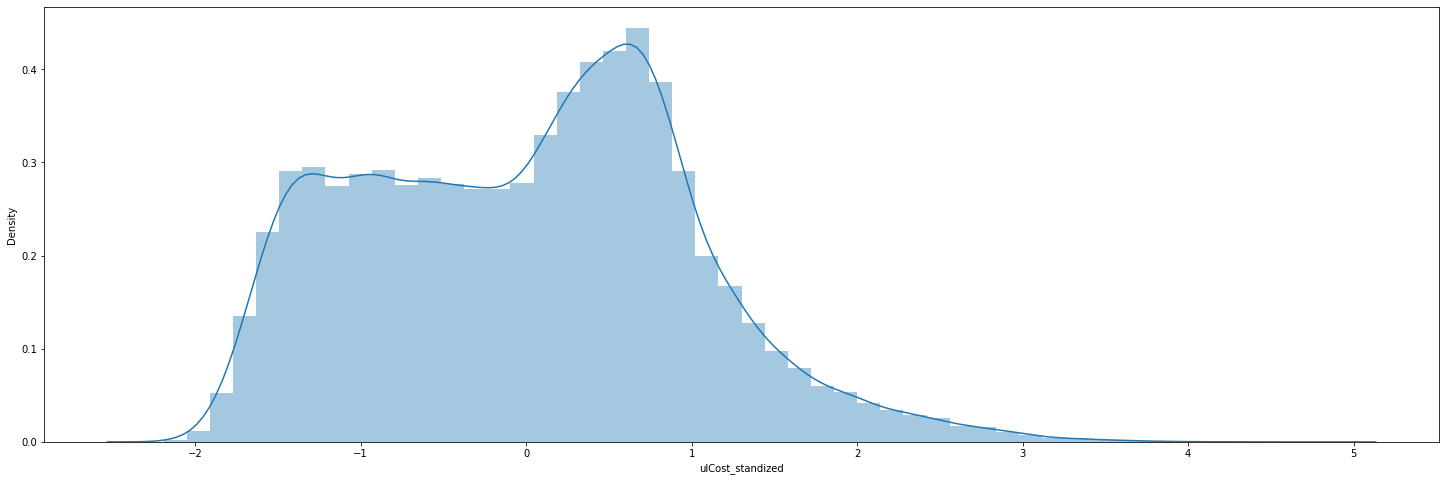

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df_ulcost_train.ulCost_standized)

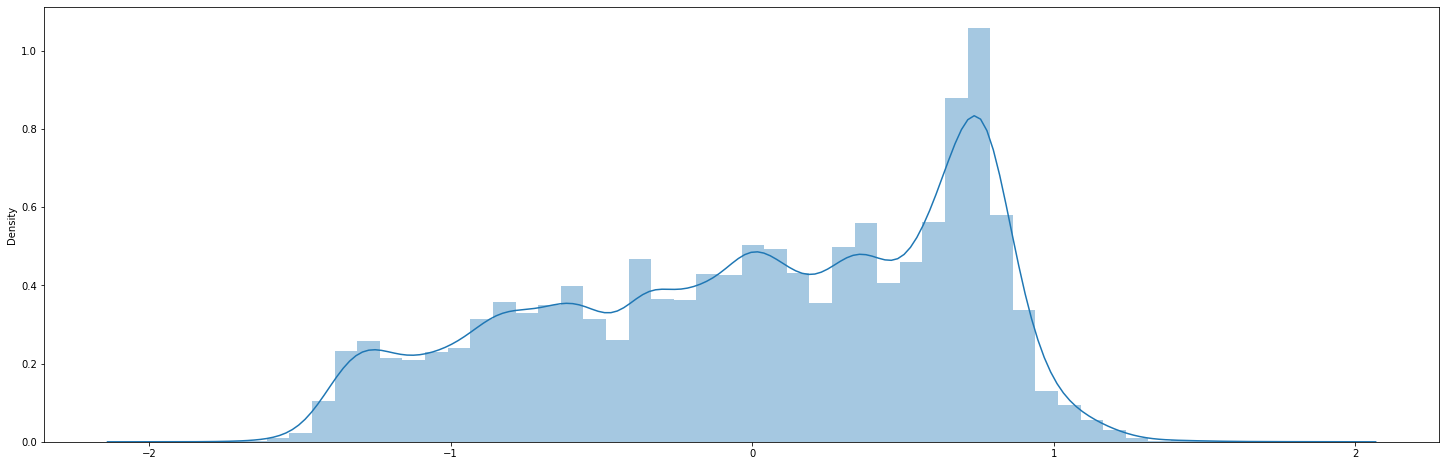

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(FittedText_ln_std)

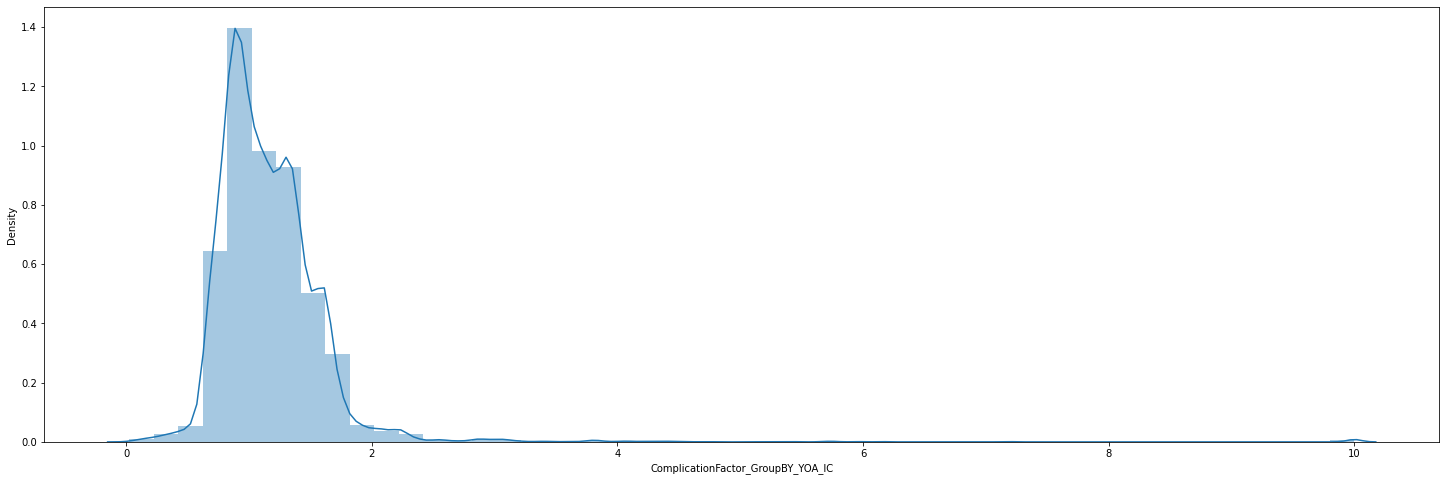

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df_train_cleaned_Xy["ComplicationFactor_GroupBY_YOA_IC"])

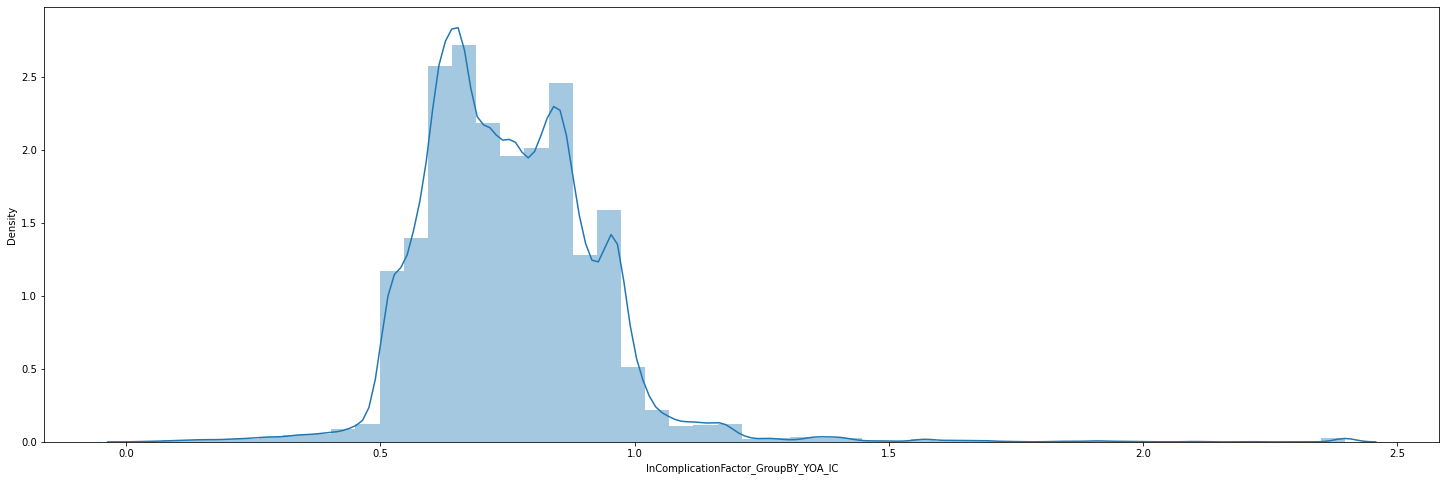

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df_train_cleaned_Xy["lnComplicationFactor_GroupBY_YOA_IC"])

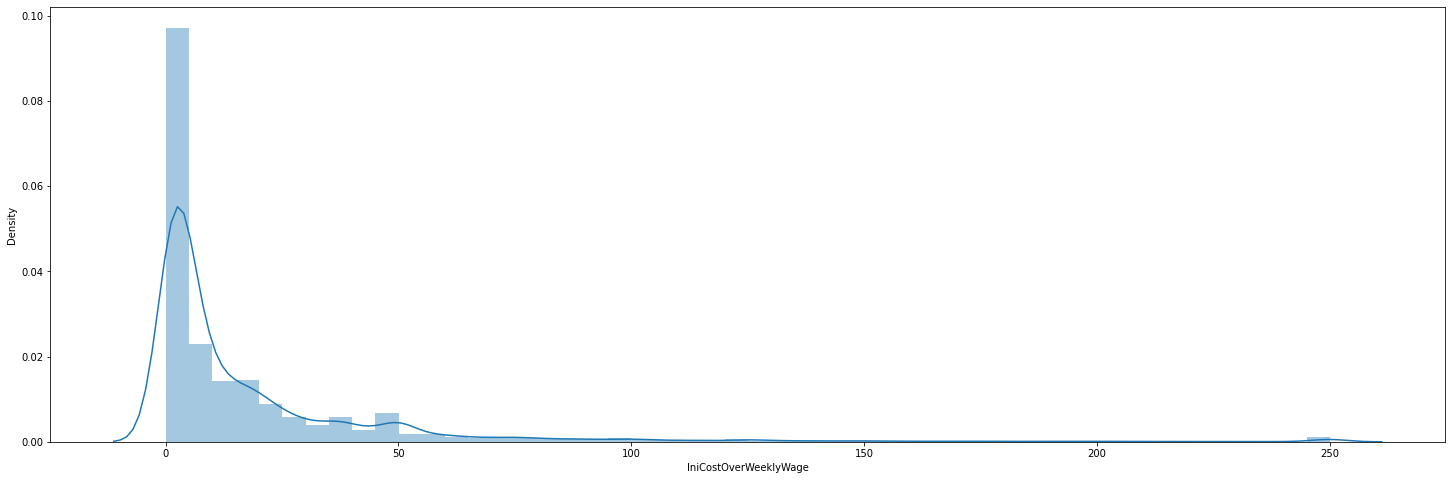

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df_train_cleaned_Xy.IniCostOverWeeklyWage)

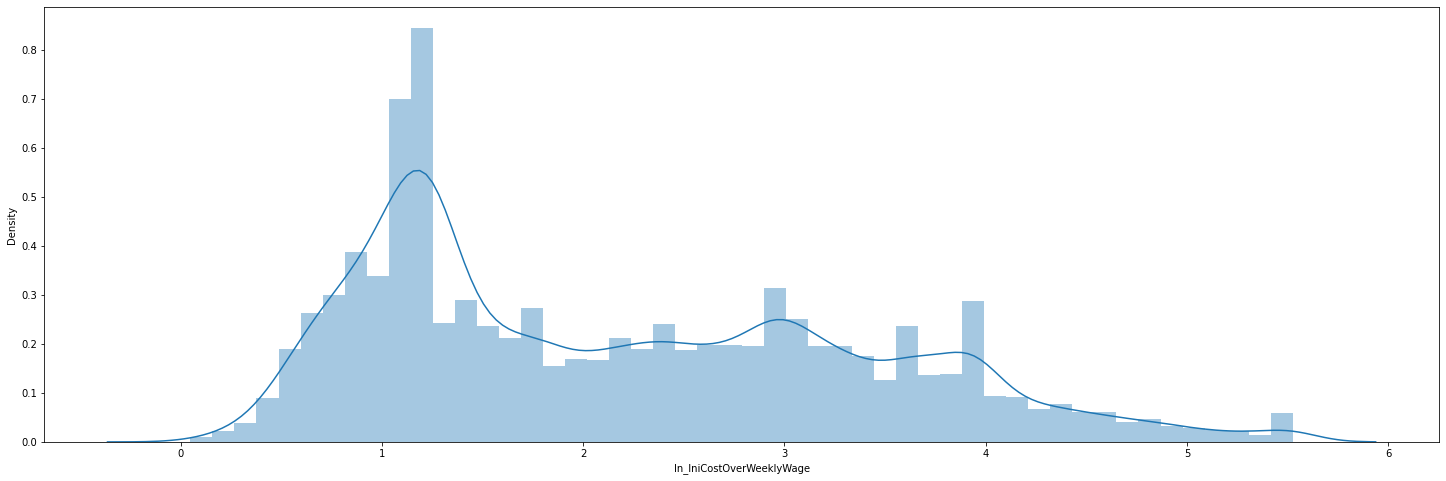

In [ ]:
plt.figure(figsize=(25,8))
sns.distplot(df_train_cleaned_Xy.ln_IniCostOverWeeklyWage)